In [91]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abhisheksjha/time-series-air-quality-data-of-india-2010-2023")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/time-series-air-quality-data-of-india-2010-2023


In [92]:
import os
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# List all files in the input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/time-series-air-quality-data-of-india-2010-2023/DL023.csv
/kaggle/input/time-series-air-quality-data-of-india-2010-2023/WB005.csv
/kaggle/input/time-series-air-quality-data-of-india-2010-2023/MH018.csv
/kaggle/input/time-series-air-quality-data-of-india-2010-2023/UP017.csv
/kaggle/input/time-series-air-quality-data-of-india-2010-2023/BR008.csv
/kaggle/input/time-series-air-quality-data-of-india-2010-2023/BR003.csv
/kaggle/input/time-series-air-quality-data-of-india-2010-2023/MP016.csv
/kaggle/input/time-series-air-quality-data-of-india-2010-2023/KA035.csv
/kaggle/input/time-series-air-quality-data-of-india-2010-2023/CH001.csv
/kaggle/input/time-series-air-quality-data-of-india-2010-2023/PY001.csv
/kaggle/input/time-series-air-quality-data-of-india-2010-2023/DL040.csv
/kaggle/input/time-series-air-quality-data-of-india-2010-2023/OR002.csv
/kaggle/input/time-series-air-quality-data-of-india-2010-2023/UP057.csv
/kaggle/input/time-series-air-quality-data-of-india-2010-2023/KL

In [93]:
import os                          # operating system interfaces
import glob                        # working with OS pathnames
import time                        # time processing
import numpy as np                 # linear algebra
import pandas as pd                # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt    # data visualization purposes
import seaborn as sns              # statistical data visualization
sns.set_theme()

# sklearn imports
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    HistGradientBoostingRegressor
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
from sklearn.model_selection import (
    cross_val_score,
    TimeSeriesSplit,
    RandomizedSearchCV
)

import xgboost as xgb                       # Extreme Gradient Boosting library
from IPython.display import clear_output    # Display function to clear notebook cell's output

In [94]:
# How many cores to use. Put -1 to use all cores.
N_JOBS = -1

# Random variable for having consistent results between runs
RANDOM_STATE = 18

# Dataset's path location
DATASET_SRC = '/kaggle/input/time-series-air-quality-data-of-india-2010-2023'

In [95]:
df_states = pd.read_csv(f'{DATASET_SRC}/stations_info.csv')
df_states.drop(columns=['agency', 'station_location', 'start_month'], inplace=True)
df_states.head()

,file_name,state,city,start_month_num,start_year
0,AP001,Andhra Pradesh,Tirupati,7,2016
1,AP002,Andhra Pradesh,Vijayawada,5,2017
2,AP003,Andhra Pradesh,Visakhapatnam,7,2017
3,AP004,Andhra Pradesh,Rajamahendravaram,9,2017
4,AP005,Andhra Pradesh,Amaravati,11,2017


In [96]:
unique_states = df_states['state'].unique()
unique_states

array(['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
       'Chhattisgarh', 'Chandigarh', 'Delhi', 'Gujarat',
       'Himachal Pradesh', 'Haryana', 'Jharkhand', 'Jammu and Kashmir',
       'Karnataka', 'Kerala', 'Maharashtra', 'Meghalaya', 'Manipur',
       'Madhya Pradesh', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab',
       'Puducherry', 'Rajasthan', 'Sikkim', 'Telangana', 'Tamil Nadu',
       'Tripura', 'Uttarakhand', 'Uttar Pradesh', 'West Bengal'],
      dtype=object)

In [97]:
def combine_state_df(state_name):
    """
    Combines all files for a given state into a single dataframe, while adding city information.

    Parameters:
    ----------
    state_name : str
        The name of the state for which data files are combined.

    Returns:
    -------
    DataFrame
        A combined dataframe containing data from all files of the specified state.
    """
    
    # Find the state code based on the state name
    state_code = df_states.loc[df_states['state'] == state_name, 'file_name'].iloc[0][:2]
    
    # Get all CSV files related to this state
    state_files = glob.glob(f'{DATASET_SRC}/{state_code}*.csv')
    print(f'Found {len(state_files)} files for {state_name}.\n')

    # List to store dataframes from each file
    combined_data = []
    
    # Iterate through each file and process it
    for state_file in state_files:
        file_df = pd.read_csv(state_file)
        file_name = os.path.basename(state_file).split('.')[0]  # Extract file name without extension
        
        # Add city information from the `df_states` dataframe
        city = df_states.loc[df_states['file_name'] == file_name, 'city'].values[0]
        file_df['city'] = city

        combined_data.append(file_df)
        
    # Combine all the dataframes in the list into a single dataframe
    return pd.concat(combined_data, ignore_index=True)


In [98]:
df = combine_state_df('Delhi')
df.info()

Found 40 files for Delhi.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2796171 entries, 0 to 2796170
Data columns (total 60 columns):
 #   Column               Dtype  
---  ------               -----  
 0   From Date            object 
 1   To Date              object 
 2   PM2.5 (ug/m3)        float64
 3   PM10 (ug/m3)         float64
 4   NO (ug/m3)           float64
 5   NO2 (ug/m3)          float64
 6   NOx (ppb)            float64
 7   NH3 (ug/m3)          float64
 8   SO2 (ug/m3)          float64
 9   CO (ug/m3)           float64
 10  Ozone (ug/m3)        float64
 11  Benzene (ug/m3)      float64
 12  Toluene ()           float64
 13  Temp (degree C)      float64
 14  RH (%)               float64
 15  WS (m/s)             float64
 16  WD (degree)          float64
 17  SR (W/mt2)           float64
 18  BP (mmHg)            float64
 19  VWS (m/s)            float64
 20  AT (degree C)        float64
 21  RF (mm)              float64
 22  city                 object 
 23  CO (m

In [99]:
def create_dt_index(dataframe):
    # Drop the 'To Date' column
    dataframe = dataframe.drop(columns='To Date')

    # Convert 'From Date' to datetime format
    dataframe['From Date'] = pd.to_datetime(dataframe['From Date'])

    # Rename 'From Date' to 'datetime' for clarity
    dataframe = dataframe.rename(columns={'From Date': 'datetime'})

    # Set 'datetime' as the index
    return dataframe.set_index('datetime')


In [100]:
df = create_dt_index(df)
df.head(2)

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),Ozone (ug/m3),Benzene (ug/m3),...,THC (ug/m3),WS (),MP-Xylene (),Benzene (),Eth-Benzene (),Xylene (),SO2 (),Ozone (ppb),Gust (kl/h),SR ()
datetime,,,,,,,,,,,,,,,,,,,,,
2018-02-01 10:00:00,322.00,487.00,4.53,26.33,18.72,24.92,11.06,0.58,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01 11:00:00,245.92,427.42,5.96,26.08,32.14,37.77,20.26,0.94,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature Reduction
As observed from the dataframe's info, some features appear to be similar. I will try to identify potential similarities between such features, and merge them.

In [101]:
# Helper function to plot groups of data into subplots
def plot_feature_similarities(dataframe, feature_groups, columns=2):
    rows = int((len(feature_groups)/columns)//1)  # Calculate rows for subplots
    fig, axes = plt.subplots(rows, columns, figsize=(13, 4*rows))  # Create subplots
    fig.tight_layout(pad=3.0)  # Adjust layout for clarity
    
    row_num = 0
    col_num = 0
    for pos, group in enumerate(feature_groups):
        # Move to new row if needed
        if pos % columns == 0 and pos != 0:
            row_num += 1
            col_num = 0
        
        # Plot each feature in the group
        for feature in feature_groups[group]:
            if feature in dataframe.columns:
                df_feature = dataframe[dataframe[feature].notnull()][feature]
                df_feature = df_feature.groupby([df_feature.index.year]).mean(numeric_only=True)  # Group by year
                sns.lineplot(data=df_feature, label=feature, ax=axes[row_num, col_num])
        
        axes[row_num, col_num].set_title(group)  # Set subplot title to group name
        axes[row_num, col_num].set(xlabel=None)  # Hide x-label for clarity
        col_num += 1
    
    plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

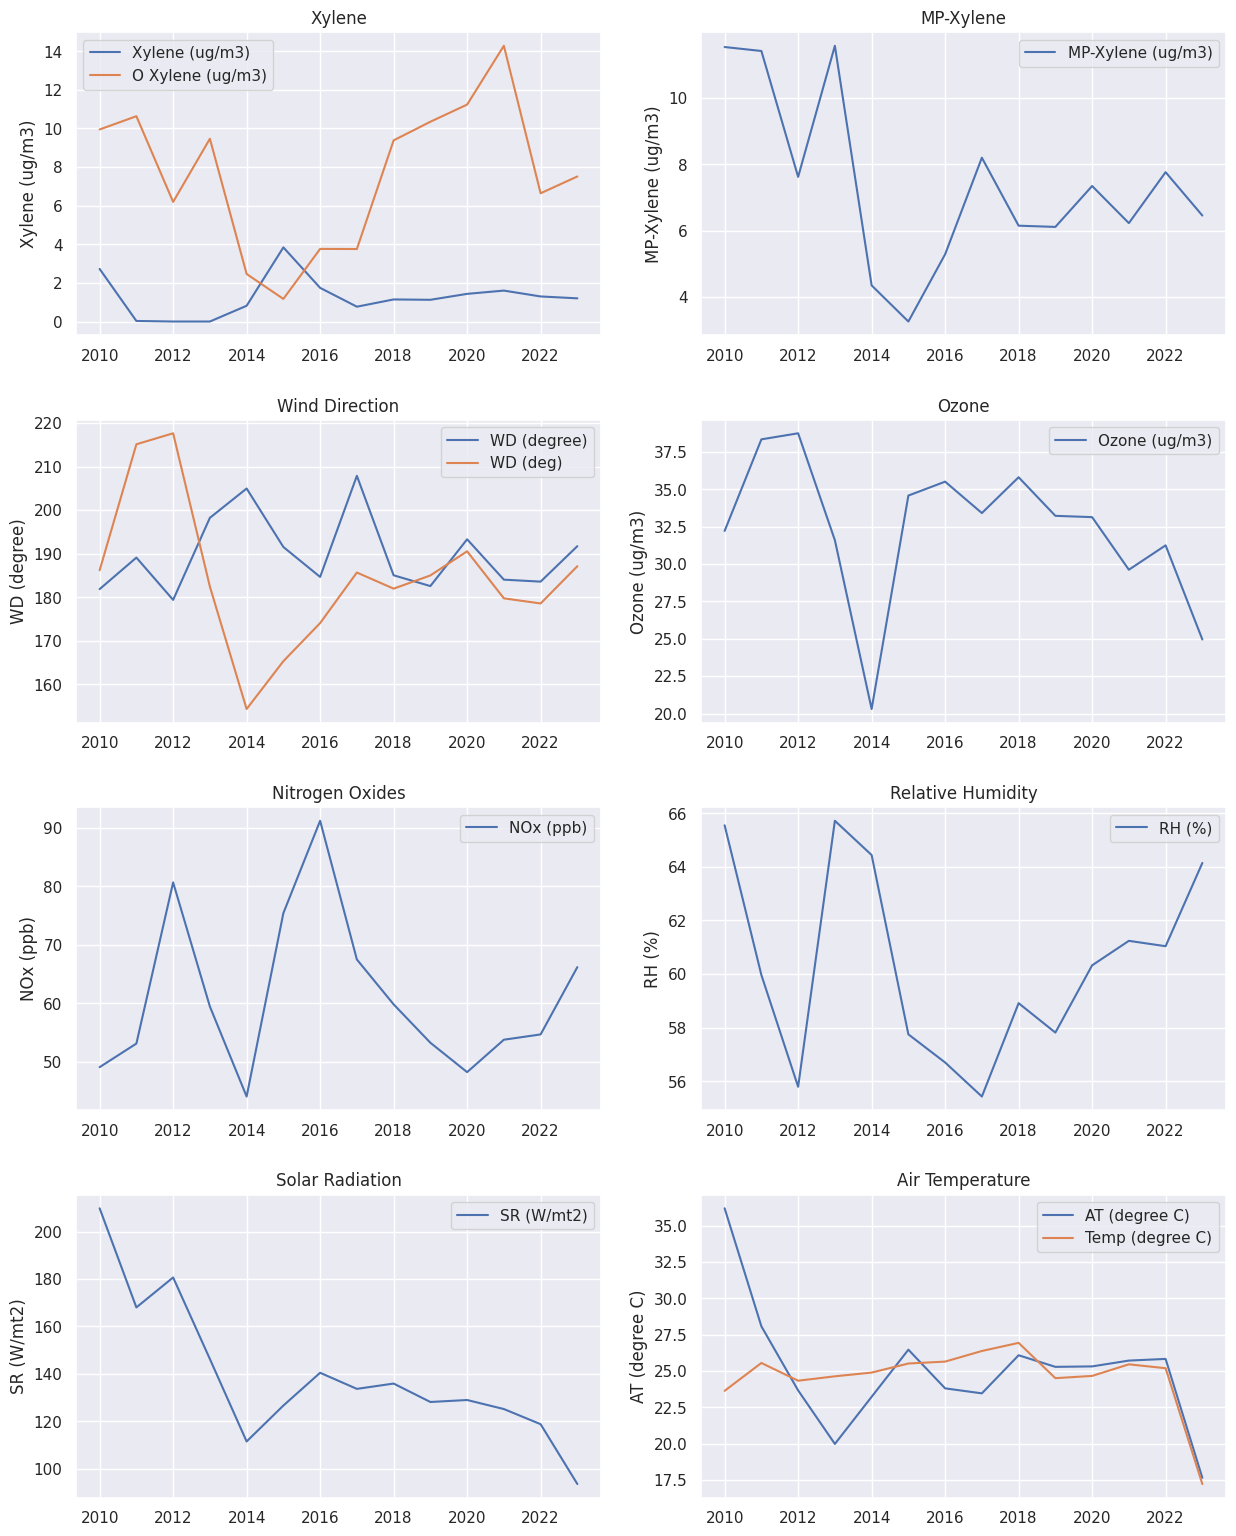

In [102]:
# Dictionary for groups of similar features
groups = {
    'Xylene':            ['Xylene (ug/m3)', 'O Xylene (ug/m3)'],  # Updated to use 'O Xylene (ug/m3)' instead of 'Xylene ()'
    "MP-Xylene":         ['MP-Xylene (ug/m3)'],  # No additional column
    'Wind Direction':    ["WD (degree)", "WD (deg)"],  # Merging 'WD (degree)' and 'WD (deg)'
    'Ozone':             ['Ozone (ug/m3)'],  # Only 'Ozone (ug/m3)' is present
    'Nitrogen Oxides':   ['NOx (ppb)'],  # Only 'NOx (ppb)' is available
    'Relative Humidity': ['RH (%)'],  # Only 'RH (%)' is available
    'Solar Radiation':   ['SR (W/mt2)'],  # Only 'SR (W/mt2)' is available
    'Air Temperature':   ['AT (degree C)', 'Temp (degree C)']  # Merging with 'Temp (degree C)'
}

# Example DataFrame (assuming it's already loaded and preprocessed with a datetime index)
# df = pd.read_csv('your_air_quality_data.csv')

# Use the plotting function with your data
plot_feature_similarities(df, groups, columns=2)

In [103]:
# List all columns from groups
all_groups = [item for sublist in list(groups.values()) for item in sublist]

# Describe the relevant features from the dataframe
print(df[all_groups].describe().applymap(lambda x: f"{x:0.3f}"))


      Xylene (ug/m3) O Xylene (ug/m3) MP-Xylene (ug/m3) WD (degree)  \
count     242944.000       184959.000        264768.000  813361.000   
mean           1.337            7.712             7.040     186.417   
std            5.762           16.016            13.603      94.905   
min            0.000            0.010             0.010       0.020   
25%            0.000            0.770             1.210     104.850   
50%            0.000            2.130             2.940     187.380   
75%            1.010            7.320             7.410     268.950   
max          476.310          460.150           491.510     360.000   

         WD (deg) Ozone (ug/m3)    NOx (ppb)       RH (%)   SR (W/mt2)  \
count  655812.000   1874697.000  1876466.000  1611483.000  1555347.000   
mean      184.905        32.370       56.894       59.893      130.106   
std        80.286        34.778       70.730       22.548      180.273   
min         0.030         0.010        0.000        0.010       

/tmp/ipykernel_30/2628744564.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(df[all_groups].describe().applymap(lambda x: f"{x:0.3f}"))


In [104]:
reduction_groups = {
    "Xylene (ug/m3)":    ["O Xylene (ug/m3)"],  # Adjusted to use the available 'O Xylene' column
    "MP-Xylene (ug/m3)": [],  # Already present, no merging needed
    "Benzene (ug/m3)":   [],  # Already present, no merging needed
    "Toluene (ug/m3)":   [],  # Already present, no merging needed
    "SO2 (ug/m3)":       [],  # Already present, no merging needed
    "NOx (ppb)":         [],  # Already present, no merging needed
    "Ozone (ug/m3)":     [],  # Already present, no merging needed
    "AT (degree C)":     ["Temp (degree C)"],  # Merging with the similar 'Temp (degree C)'
    "WD (degree)":       ["WD (deg)"],  # Merging 'WD (degree)' and 'WD (deg)'
    "WS (m/s)":          []  # Already present, no merging needed
}


In [105]:
# Function to merge redundant columns
def merge_columns(dataframe, columns):
    '''
    Merges redundant columns into a single main column.
    
    Parameters:
    dataframe (pd.DataFrame): The dataframe to edit
    columns (dict): A dictionary where keys are main columns and values are lists of columns to merge
    
    Returns:
    dataframe (pd.DataFrame): The updated dataframe with merged columns
    '''
    
    for column, cols_to_merge in columns.items():
        # Check if any of the columns to merge exist in the DataFrame
        existing_cols = [col for col in cols_to_merge if col in dataframe.columns]
        
        # Proceed only if there are columns to merge
        if existing_cols:
            # Create the main column if it doesn't exist
            if column not in dataframe.columns:
                dataframe[column] = np.nan

            # Merge the existing columns into the main column
            for col_name in existing_cols:
                dataframe[column] = dataframe[column].fillna(dataframe[col_name])
                dataframe = dataframe.drop(columns=[col_name])  # Drop the merged column
            
    return dataframe

# Apply the merge function to your DataFrame
df = merge_columns(df, reduction_groups)
df.head()


,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (ug/m3),Ozone (ug/m3),Benzene (ug/m3),...,THC (ug/m3),WS (),MP-Xylene (),Benzene (),Eth-Benzene (),Xylene (),SO2 (),Ozone (ppb),Gust (kl/h),SR ()
datetime,,,,,,,,,,,,,,,,,,,,,
2018-02-01 10:00:00,322.00,487.00,4.53,26.33,18.72,24.92,11.06,0.58,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01 11:00:00,245.92,427.42,5.96,26.08,32.14,37.77,20.26,0.94,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01 12:00:00,176.67,368.83,2.70,15.93,18.62,38.67,12.48,0.73,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01 13:00:00,149.00,333.75,1.33,11.37,23.08,24.69,4.28,0.61,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01 14:00:00,113.08,273.25,1.22,15.52,33.15,7.96,0.53,0.52,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Missing Values
One important first thing to check now is how many missing values there are for these features.

In [106]:
df.isnull().sum().sort_values(ascending=False)

Variance (n)           2796171
SPM (ug/m3)            2796171
Power (W)              2796171
CO2 (mg/m3)            2796171
Gust (km/hr)           2796171
Temp (ug/m3)           2796171
NMHC (ug/m3)           2796171
Gust (m/s)             2796171
Eth-Benzene ()         2796171
Gust (kl/h)            2796171
CH4 ()                 2785343
MP-Xylene ()           2766966
HCHO (ug/m3)           2762343
Xylene ()              2761593
Hg (ug/m3)             2761020
MH (m)                 2758723
SO2 ()                 2756881
BP ()                  2756663
RH ()                  2756449
SR ()                  2752904
CO (ng/m3)             2752432
WD (degree C)          2752283
Ozone (ppb)            2748595
CH4 (ug/m3)            2734776
THC (ug/m3)            2733520
Benzene ()             2718736
Toluene ()             2717842
AT ()                  2713155
CO (ug/m3)             2712197
NOx (ug/m3)            2710085
WS ()                  2678359
WD ()                  2673708
Eth-Benz

In [107]:
df = df.dropna(how='all')
df = df.dropna(how='all', axis='columns')

In [108]:
# Helper function that returs a DataFrame containing the number of null values and percentages for each column
def get_null_info(dataframe):
    null_vals = dataframe.isnull().sum()

    df_null_vals = pd.concat({'Null Count': null_vals,
                              'Percent Missing (%)': round(null_vals * 100 / len(dataframe), 2)}, axis=1)

    return df_null_vals.sort_values(by=['Null Count'], ascending=False)

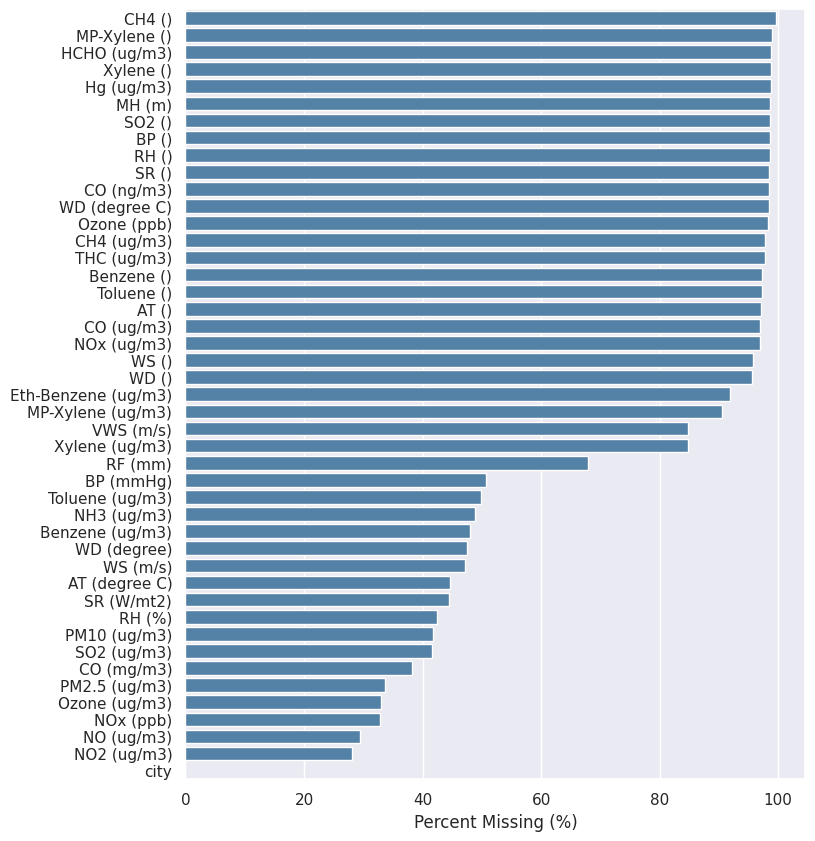

In [109]:
df_null_info = get_null_info(df)

plt.figure(figsize=(8, 10))
sns.barplot(data=df_null_info, x='Percent Missing (%)', y=df_null_info.index, orient='h', color='steelblue')
plt.show()

# Dataset's Null Count Information
So far we investigated only a single state. We may get a better feeling for the missing data if we investigate the complete dataset.

In [110]:
def get_overall_ds_info():
    features = {}
    total_records = 0

    for i, state_name in enumerate(unique_states):
        clear_output(wait=False)
        print(f"Processing state of {state_name} ({i+1}/{len(unique_states)})")

        temp_df = combine_state_df(state_name)  # Get combined state dataframe
        temp_df = create_dt_index(temp_df)      # Create datetime index
        temp_df = temp_df.dropna(how='all')     # Drop empty rows

        comparisons = get_null_info(temp_df)

        total_records += df.shape[0]

        for feature in comparisons.index:
            if feature in features:
                features[feature] += comparisons.loc[[feature]]['Null Count'].values[0]
            else:
                features[feature] = comparisons.loc[[feature]]['Null Count'].values[0]
                
    ds_null_info = pd.DataFrame.from_dict(features, orient='index', columns=['Null Count'])
    ds_null_info['Percent Missing (%)'] = round(ds_null_info['Null Count'] * 100 / total_records, 2)
    ds_null_info = ds_null_info.sort_values(by=['Null Count'], ascending=False)
    return ds_null_info


Processing state of West Bengal (31/31)
Found 14 files for West Bengal.



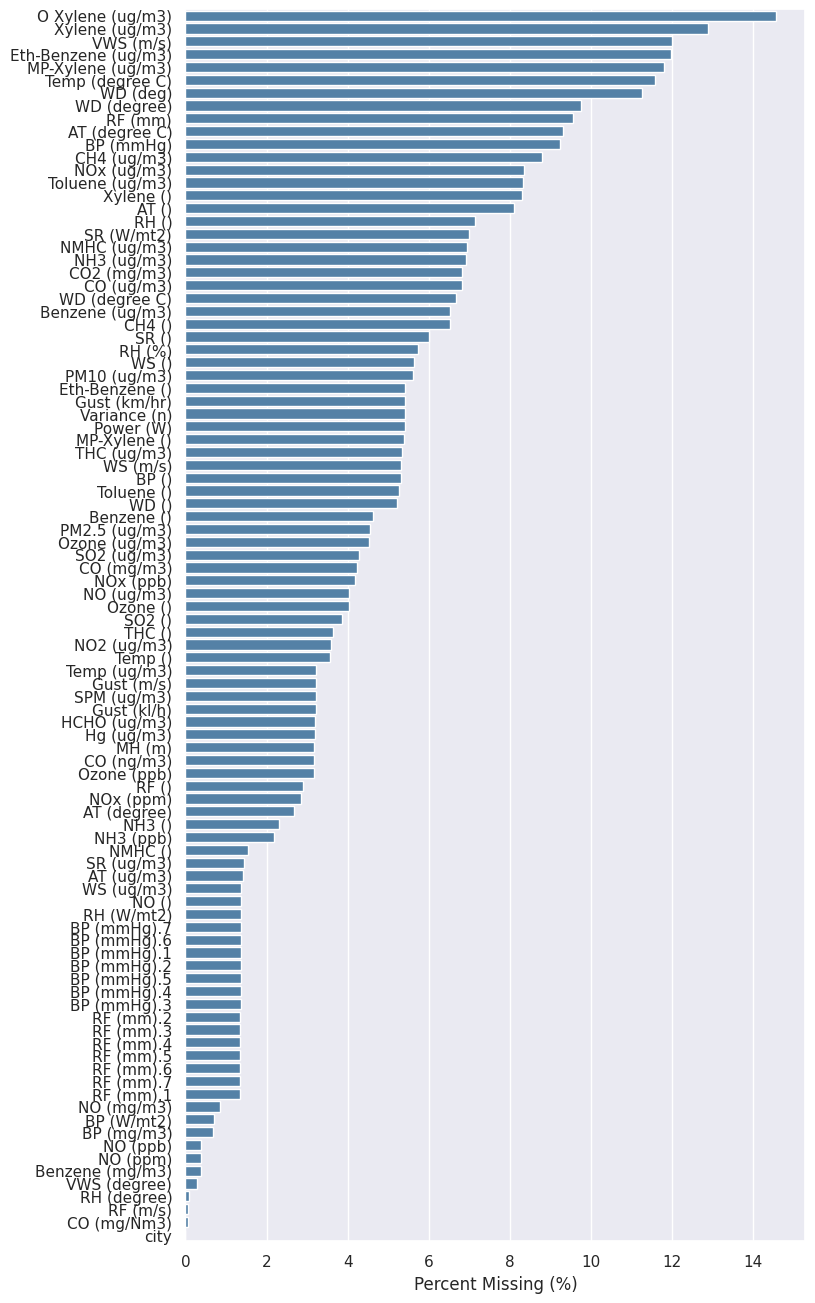

In [111]:
overall_ds_info = get_overall_ds_info()

plt.figure(figsize=(8, 16))
sns.barplot(data=overall_ds_info, x='Percent Missing (%)', y=overall_ds_info.index, orient='h', color='steelblue')
plt.show()

# Drop Nulls by Threshold
Back to our capital's dataframe, we can drop the columns which contain a certain thrueshold (i.e > 40%) of missing values.

In [112]:
# Threshold value indicating how much of the dataset needs to be not missing.
threshold = 0.6
df = df.dropna(thresh=df.shape[0]*threshold, axis=1)

In [113]:
get_null_info(df)

,Null Count,Percent Missing (%)
CO (mg/m3),1070972,38.30
PM2.5 (ug/m3),939895,33.61
Ozone (ug/m3),921474,32.95
NOx (ppb),919705,32.89
NO (ug/m3),821483,29.38
NO2 (ug/m3),783452,28.02
city,0,0.00


# Exploratory Data Analysis (EDA)
I am collecting the metrics (features) into several groups. This will enable better comparisons.

In [114]:
# Define pollutants and other metrics as per your project requirements
pollutants = {
    # A mixture of solid particles and liquid droplets found in the air.
    'Particulate Matter': ['PM2.5 (ug/m3)', 'PM10 (ug/m3)'],

    # Nitrogen gases form when fuel is burned at high temperatures.
    'Nitrogen Compounds': ['NOx (ppb)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NH3 (ug/m3)'],

    # These are found in coal tar, crude petroleum, paint, vehicle exhausts, and industrial emissions.
    'Hydrocarbons': ['Benzene (ug/m3)', 'Eth-Benzene (ug/m3)', 'Xylene (ug/m3)', 'MP-Xylene (ug/m3)', 'O Xylene (ug/m3)', 'Toluene (ug/m3)'],

    # Released from the partial combustion of carbon-containing compounds.
    'Carbon Monoxide': ['CO (mg/m3)'],

    # Released naturally by volcanic activity and is produced as a by-product of copper extraction and the burning of sulfur-bearing fossil fuels.
    'Sulfur Dioxide': ['SO2 (ug/m3)'],

    # It is created mostly from the combustion of fossil fuels.
    'Ozone Concentration': ['Ozone (ug/m3)']
}

other_metrics = {
    # Affects Earth's average temperatures
    'Solar Radiation': ['SR (W/mt2)'],

    'Temperatures': ['Temp (degree C)', 'AT (degree C)'],

    'Relative Humidity': ['RH (%)'],

    'Rainfall': ['RF (mm)'],

    'Barometric Pressure': ['BP (mmHg)'],

    'Wind Direction': ['WD (degree)'],

    'Wind Speed': ['WS (m/s)']
}

# Time Frequencies
Let's start by grouping our DataFrame by various frequencies

In [115]:
# Group the DataFrame by day, month, and year
slice_groups = {
    'Group by Day': df.groupby(pd.Grouper(freq='1D')).mean(numeric_only=True),
    'Group by Month': df.groupby(pd.Grouper(freq='1ME')).mean(numeric_only=True),
    'Group by Year': df.groupby(pd.Grouper(freq='1YE')).mean(numeric_only=True)
}

In [116]:
def plot_features_by_group(features, slice_groups):
    for feature in features:
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        fig.suptitle(feature)

        labels = []
        for i, (group, group_df) in enumerate(slice_groups.items()):
            # Select only the columns corresponding to the current feature
            data_slice = group_df[group_df.columns.intersection(pollutants[feature])]

            # Drop non-numeric columns
            data_slice = data_slice.select_dtypes(include='number')

            # Handle Nitrogen Compounds specifically by dropping individual NO and NO2
            if feature == "Nitrogen Compounds":
                data_slice = data_slice.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1, errors='ignore')

            # Only plot if there's data available
            if not data_slice.empty:
                data_slice.plot(kind="line", ax=ax)

                for column in data_slice.columns:
                    labels.append(f'{column} [{group}]')

        ax.set(xlabel=None)
        ax.legend(labels)
        plt.plot()

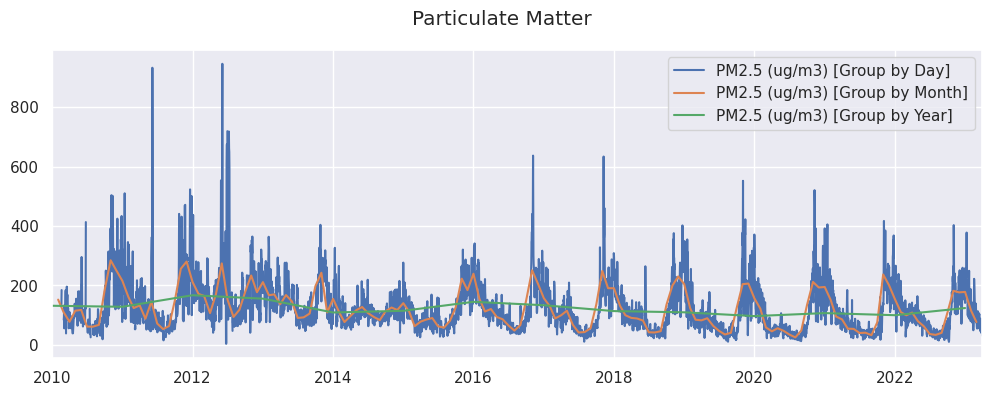

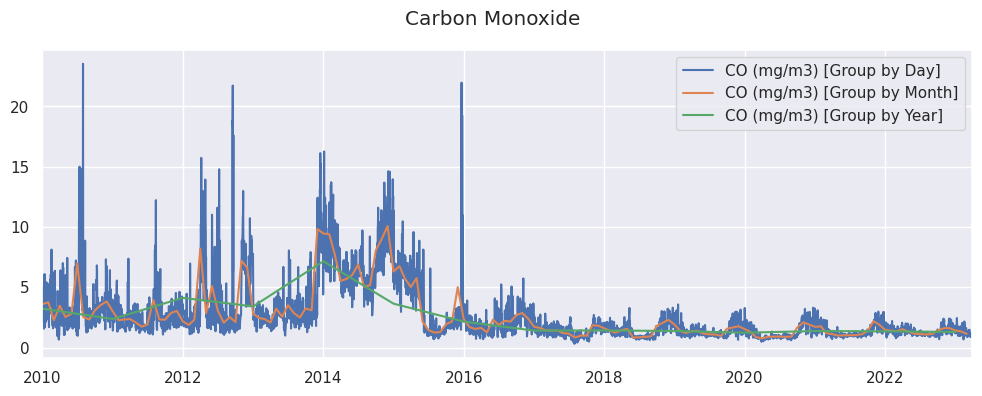

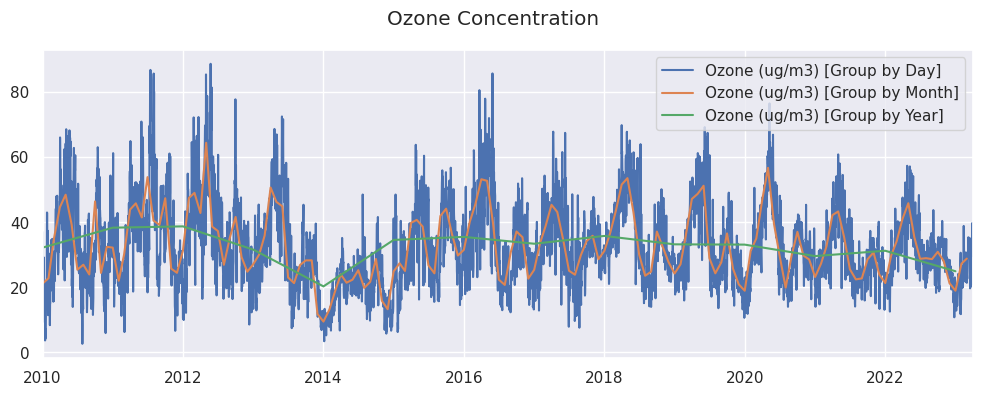

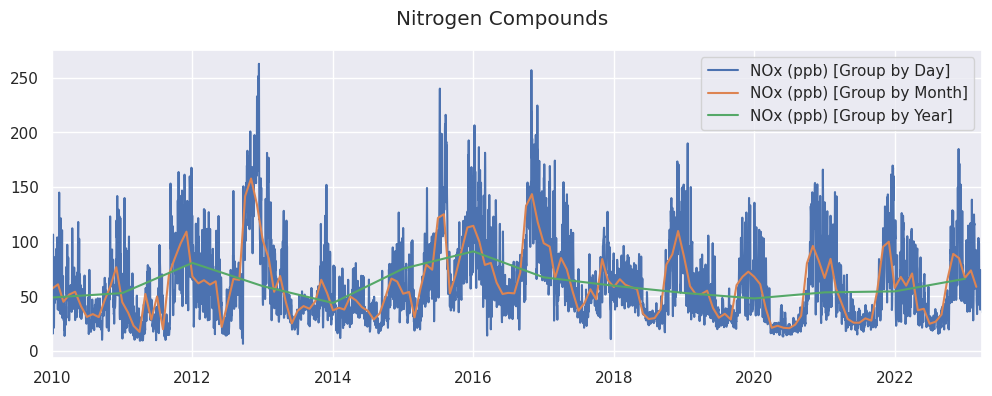

In [117]:
# List of features to plot based on your project requirements
features_to_plot = ['Particulate Matter', 'Carbon Monoxide', 'Ozone Concentration', 'Nitrogen Compounds']

# Call the plotting function with the desired features
plot_features_by_group(features_to_plot, slice_groups)

# Year Slices
It looks like we are dealing with seasonal patterns on the metrics we selected. Let's dive a little bit deeper and try to understand what's happening per season on a yearly basis. For example let's consider a slice of the data, such as the year 2019-2020.

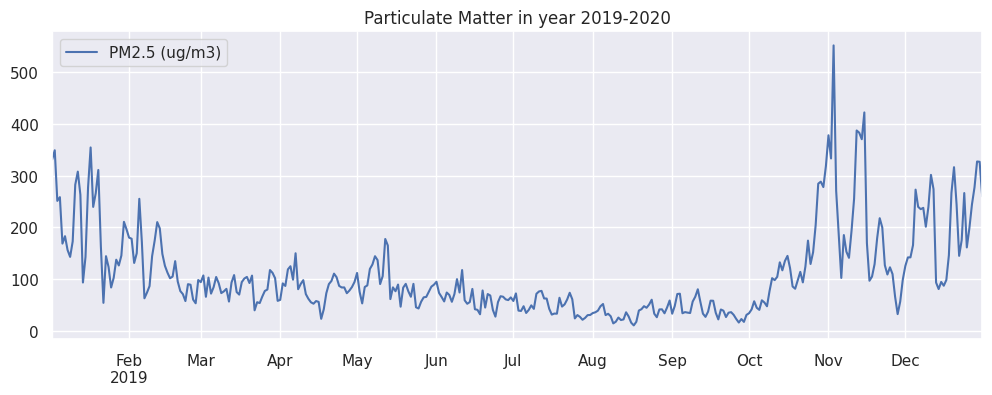

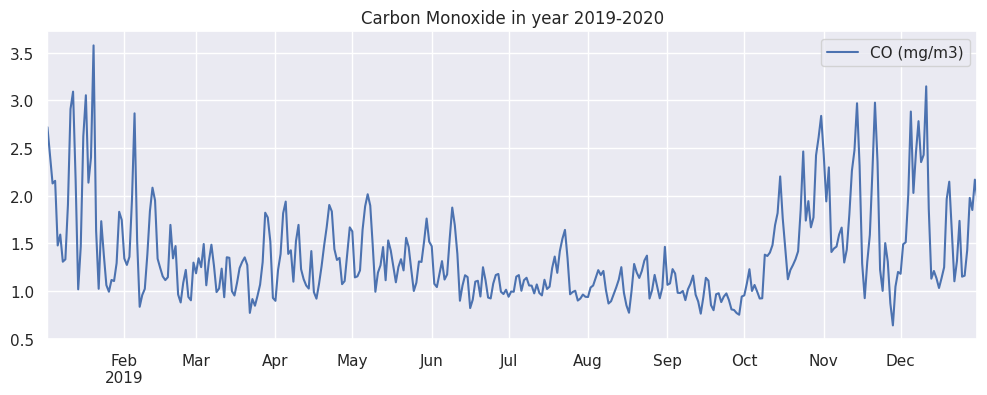

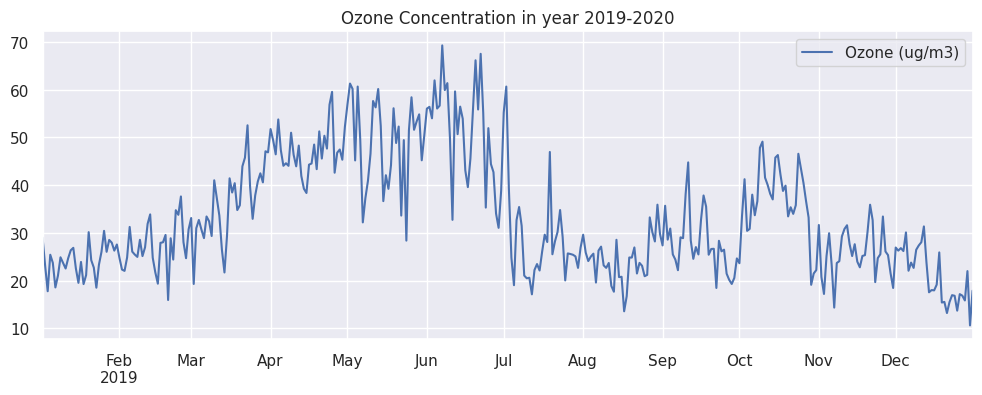

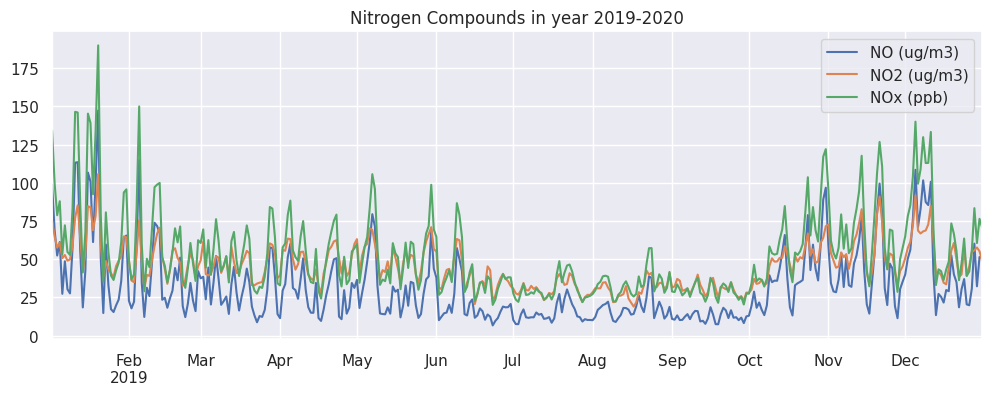

In [118]:
for feature in features_to_plot:
    data_slice = slice_groups['Group by Day'][slice_groups['Group by Day'].columns.intersection(pollutants[feature])]
    data_slice.query('datetime > 2019 and datetime < 2020').plot(title=f'{feature} in year 2019-2020', figsize=(12,4)).set(xlabel=None)

Here we can see that the values for the Particulate Mater, Nitrogen Compounds and Carbon Monoxide, start to increase around October and last until approxamatelly March. For the Ozone Concentration metric we see an opposite result, where the maximum values in a year are around mid May/June.
ot.

# PairPlot

We can see a better explanation on the relationships between the variables, as well as the distribution of each one through a pair plot.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

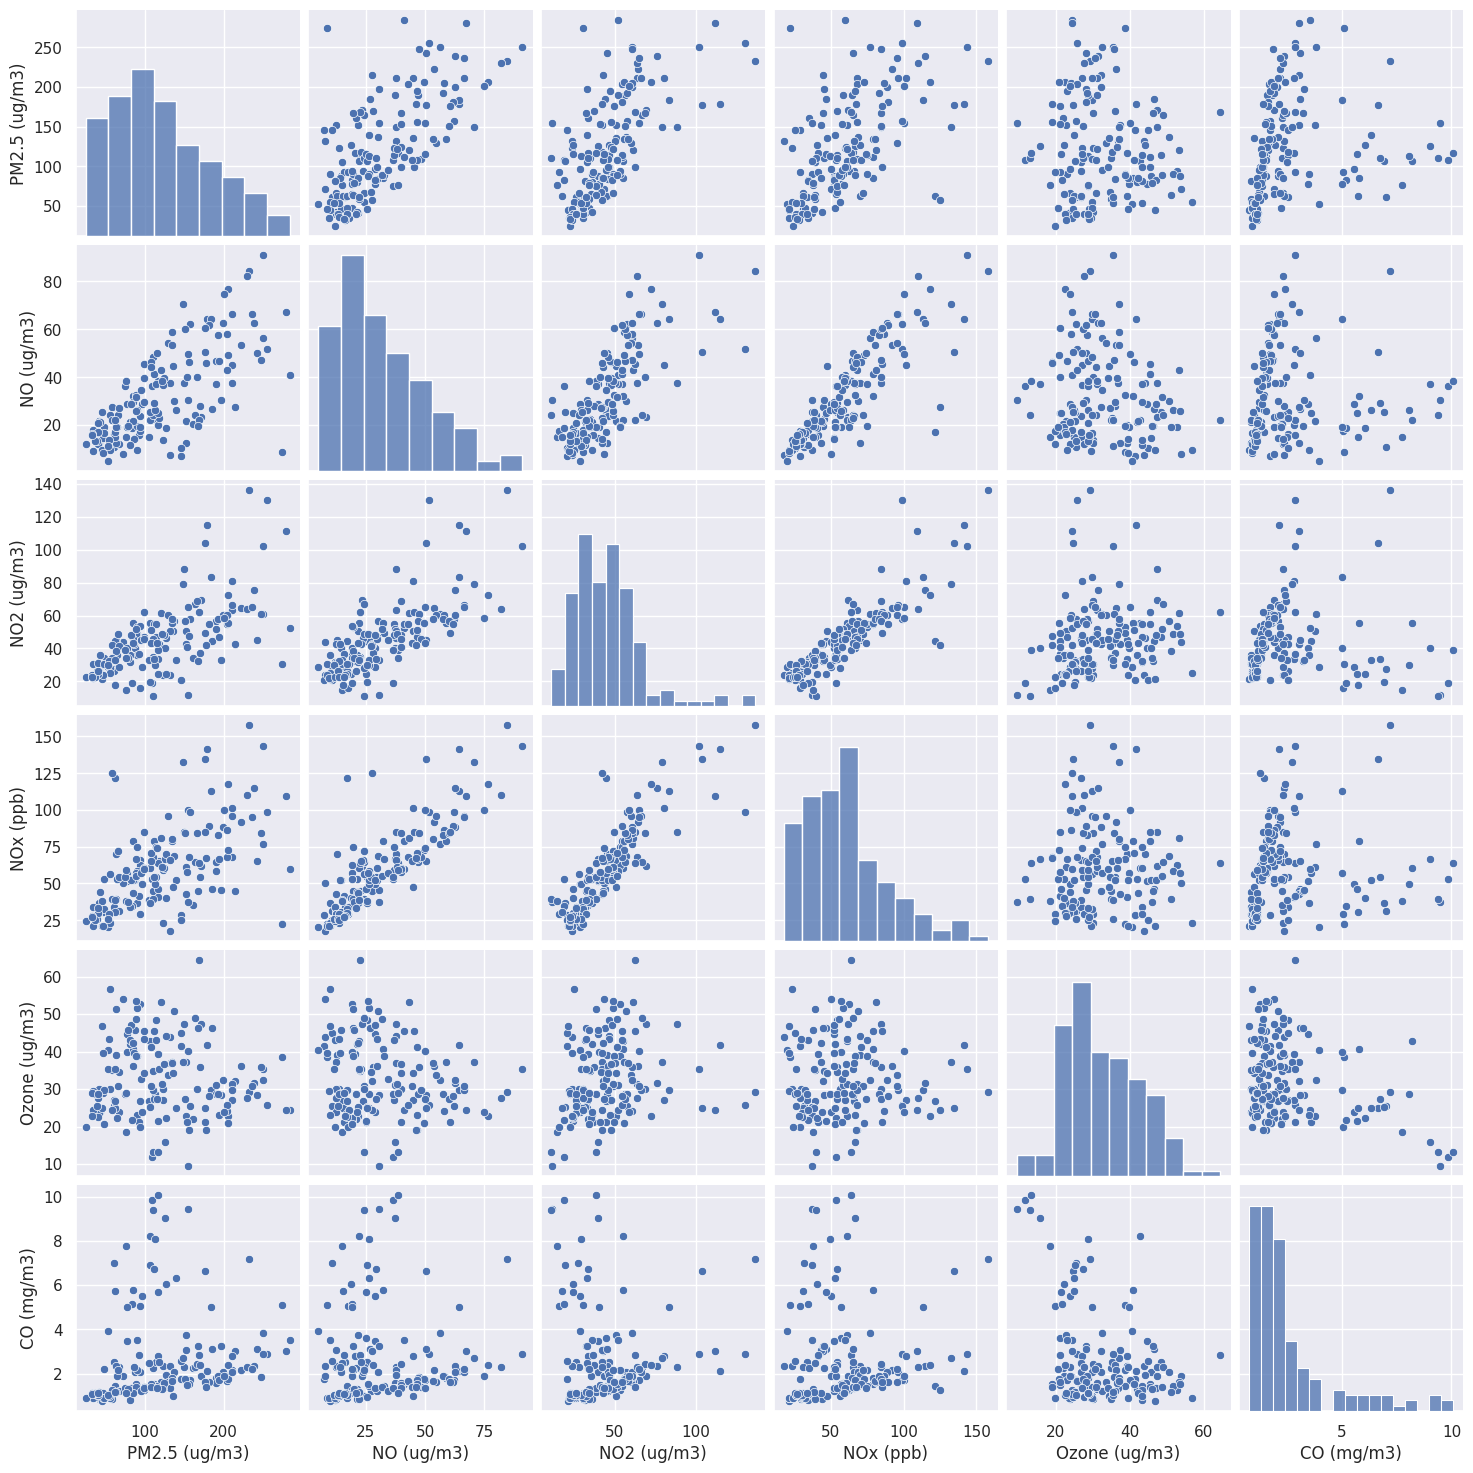

In [119]:
sns.pairplot(slice_groups['Group by Month'])

We can definatelly see here that the correlation between the Nitrogen Oxydes (NOx, NO, NO2) is quite linear. This is expected and we should probably just keep the generic feature, which is NOx.

# Correlation Matrix
Through a correlation matrix, we can easily visuallize the correlation degree between the variables.

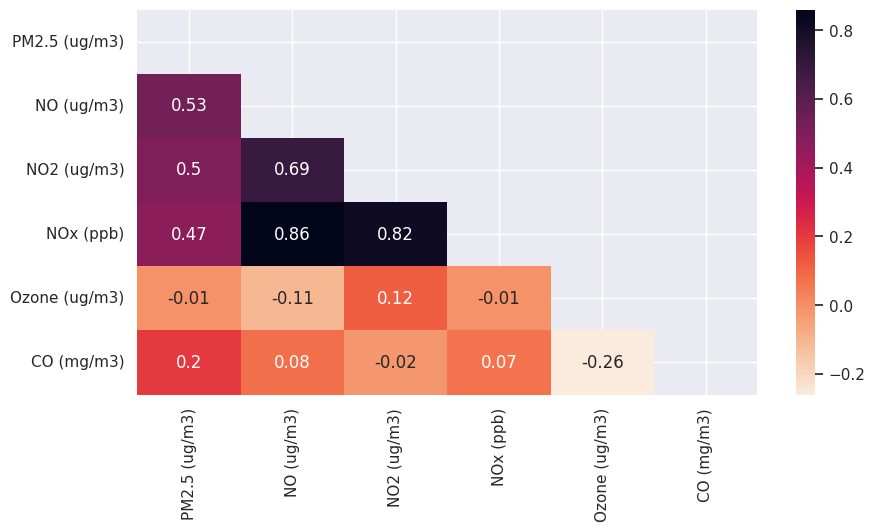

In [120]:
corr = slice_groups['Group by Day'].corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,5))
sns.heatmap(data=corr, mask=mask, annot=True, cmap="rocket_r")
plt.show()

In [121]:
corr_target = abs(corr['PM2.5 (ug/m3)'])
relevant_features = corr_target[corr_target>0.4]
relevant_features.sort_values(ascending=False)

PM2.5 (ug/m3)    1.00
NO (ug/m3)       0.53
NO2 (ug/m3)      0.50
NOx (ppb)        0.47
Name: PM2.5 (ug/m3), dtype: float64

This plot shows us various high correlated features. For example:
*  
NOx is strongly correlated with the features NO and NO2
* The particle accumulation feature PM2.5 increases as the   values of NOx increase


ease.
Again, we see that it is fairly normal for the values of the Nitrogen Compounds to be highly correlated, as they represented in the same group.

# Feature Engineering
Drop Correlated Features

In [122]:
df = df.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)

# Resampling
Secondly, this combined dataframe can contain data for the same timeframe as measurements ware made from various locations within the state. Here as I am interested in exploring the air quality in one state at a time, I will resample the same datetime measurements by taking the mean of the measurements.

In [123]:
df = df.resample('60min').mean(numeric_only=True)
df.head()

,PM2.5 (ug/m3),NOx (ppb),Ozone (ug/m3),CO (mg/m3)
datetime,,,,
2010-01-01 00:00:00,NaN,73.7425,26.0650,2.340000
2010-01-01 01:00:00,NaN,36.0000,20.3425,2.327500
2010-01-01 02:00:00,NaN,27.1900,11.0650,2.177500
2010-01-01 03:00:00,NaN,21.1125,18.4625,1.992500
2010-01-01 04:00:00,NaN,23.1550,13.7500,2.096667


# Outlier Detection and Removal
In general outliers are able to distort analyses and skew results. They are extreme values that can greatly differ from the rest of the data. By removing the influence of such extreme data points we can make more robust and accurate predictions.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

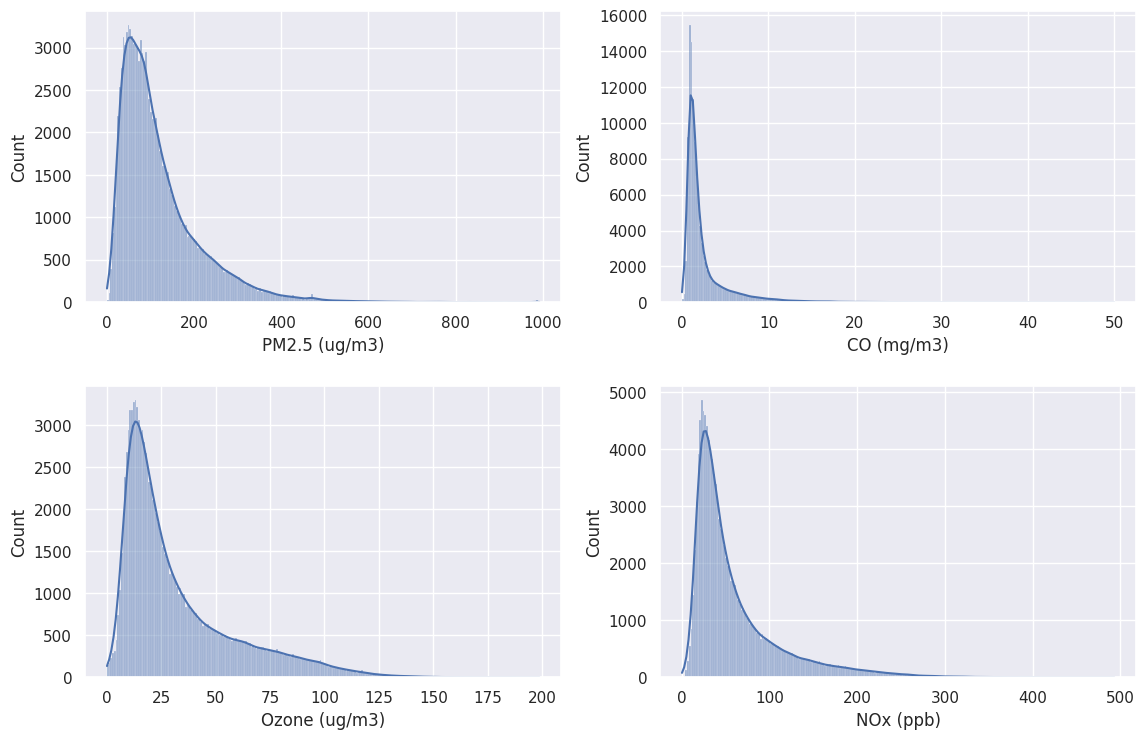

In [124]:
# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(pad=3.0)

# Plotting histograms with KDE for the specified pollutants
sns.histplot(data=df['PM2.5 (ug/m3)'], bins=250, kde=True, ax=axes[0, 0])
sns.histplot(data=df['CO (mg/m3)'], bins=250, kde=True, ax=axes[0, 1])
sns.histplot(data=df['Ozone (ug/m3)'], bins=250, kde=True, ax=axes[1, 0])
sns.histplot(data=df['NOx (ppb)'], bins=250, kde=True, ax=axes[1, 1])  # Use 'NOx (ppb)'

plt.show()

count    112235.000000
mean        122.095959
std          95.467293
min           0.470000
25%          56.721491
50%          94.405000
75%         156.878500
max         991.500000
Name: PM2.5 (ug/m3), dtype: float64
3877
float64


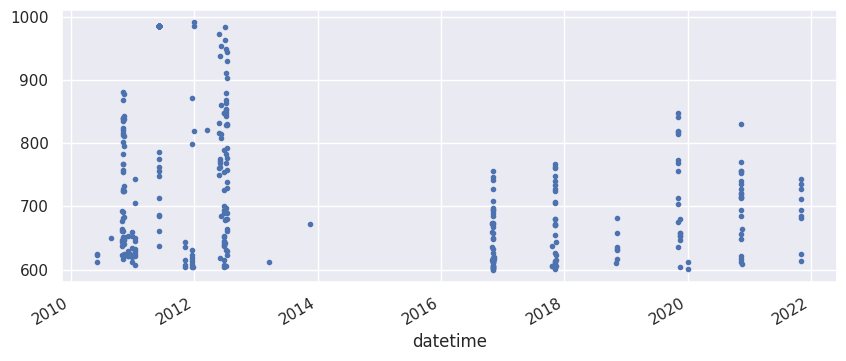

In [125]:
# Check for data type and describe the PM2.5 column
print(df['PM2.5 (ug/m3)'].describe())
print(df['PM2.5 (ug/m3)'].isnull().sum())
print(df['PM2.5 (ug/m3)'].dtype)

# Convert to numeric if necessary
df['PM2.5 (ug/m3)'] = pd.to_numeric(df['PM2.5 (ug/m3)'], errors='coerce')

# Query and plot
filtered_data = df.query('`PM2.5 (ug/m3)` > 600')['PM2.5 (ug/m3)']
if not filtered_data.empty:
    filtered_data.plot(style='.', figsize=(10, 4))
else:
    print("No data available for PM2.5 greater than 600.")

Here we can probably notice that we have just a few outliers above 950 around the year of 2012. I am going to remove them with caution.

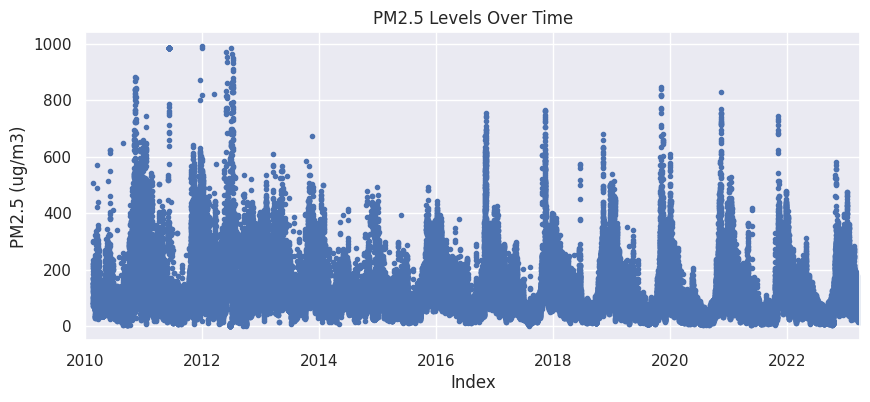

In [126]:
df['PM2.5 (ug/m3)'].plot(style='.', figsize=(10, 4))
plt.title('PM2.5 Levels Over Time')
plt.xlabel('Index')
plt.ylabel('PM2.5 (ug/m3)')
plt.show()


In [127]:
df['PM2.5 (ug/m3)'] = df['PM2.5 (ug/m3)'].mask(df['PM2.5 (ug/m3)'].gt(950))

Next we explore potential outliers on the Carbon Monoxide (CO) feature.

<Axes: xlabel='datetime'>

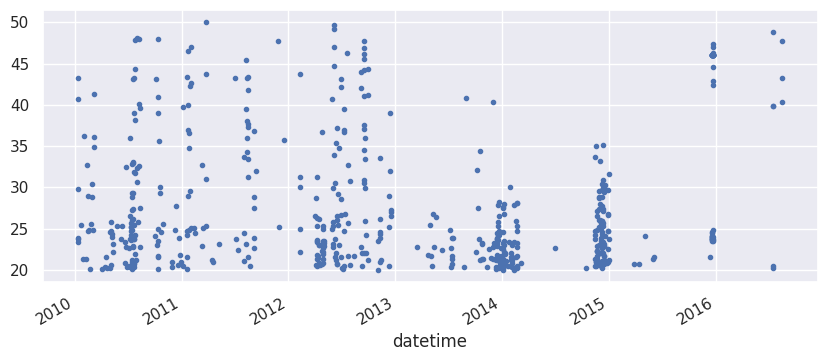

In [128]:
df.query('`CO (mg/m3)` > 20')['CO (mg/m3)'].plot(style='.', figsize=(10,4))

As you can see, this feature is quite noisy. However there is a group that caught my attention on the right side of the plot and after the year 2015. I will try to remove it.

In [129]:
df['CO (mg/m3)'] = df['CO (mg/m3)'].mask(((df.index > '2015') & df['CO (mg/m3)'].gt(35)))

Let's also explore the Ozone feature.

<Axes: xlabel='datetime'>

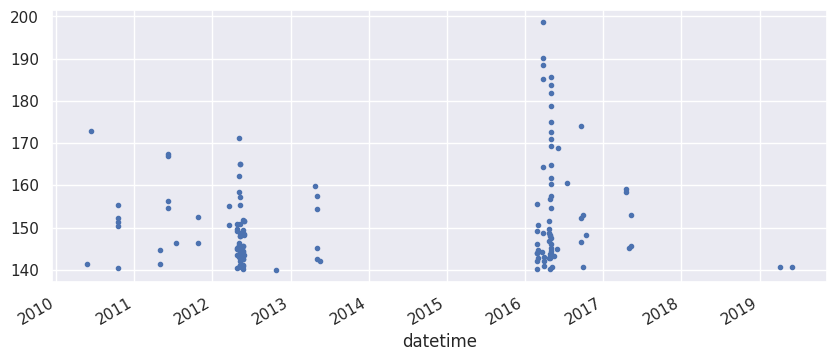

In [130]:
df.query('`Ozone (ug/m3)` > 140')['Ozone (ug/m3)'].plot(style='.', figsize=(10,4))

Here the outliers seem to be limited only around the middle 2016. I will just trim the extreme part of these measurements.

In [131]:
df['Ozone (ug/m3)'] = df['Ozone (ug/m3)'].mask(df['Ozone (ug/m3)'].gt(185))

Lastly we take a look at the Nitrogen Compounds (NOx) feature.

<Axes: xlabel='datetime'>

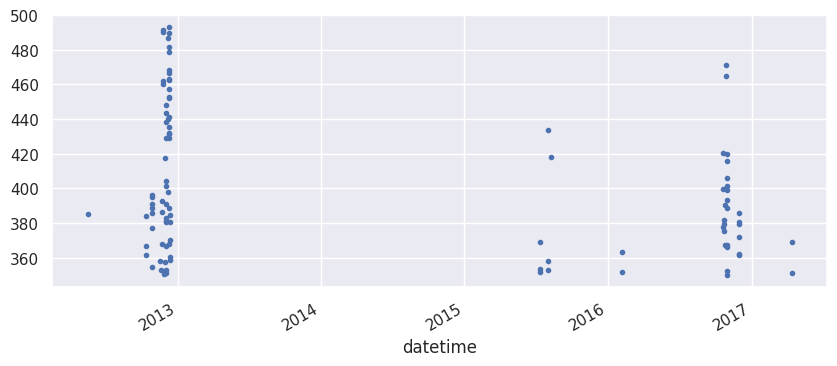

In [132]:
df[df['NOx (ppb)'] > 350]['NOx (ppb)'].plot(style='.', figsize=(10, 4))


Again, we notice just a few extreme points that may be error data points. I will eliminate those.

In [133]:
df['NOx (ppb)'] = df['NOx (ppb)'].mask((
    ((df.index < '2013') & (df['NOx (ppb)'].gt(380))) |
    ((df.index > '2015') & (df.index < '2016') & (df['NOx (ppb)'].gt(400))) |
    ((df.index > '2016') & (df['NOx (ppb)'].gt(450)))
))


Handling Missing Values

In [134]:
get_null_info(df)

,Null Count,Percent Missing (%)
PM2.5 (ug/m3),3908,3.37
CO (mg/m3),2123,1.83
NOx (ppb),104,0.09
Ozone (ug/m3),67,0.06


In [135]:
df = df.interpolate(method='pad')
df = df.fillna(df.mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116112 entries, 2010-01-01 00:00:00 to 2023-03-31 23:00:00
Freq: 60min
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   PM2.5 (ug/m3)  116112 non-null  float64
 1   NOx (ppb)      116112 non-null  float64
 2   Ozone (ug/m3)  116112 non-null  float64
 3   CO (mg/m3)     116112 non-null  float64
dtypes: float64(4)
memory usage: 4.4 MB


/tmp/ipykernel_30/1820669235.py:1: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.interpolate(method='pad')


# Date Component Features
Let's prepare our dataset by enhancing it with useful features and separating it into training/testing splits.

In [136]:
def create_features(df):
    df = df.copy()
    df['hour']       = df.index.hour
    df['dayofmonth'] = df.index.day
    df['dayofweek']  = df.index.dayofweek
    df['dayofyear']  = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype("int64")
    df['month']      = df.index.month
    df['quarter']    = df.index.quarter
    df['year']       = df.index.year
    return df

In [137]:
date_features = ['hour', 'dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year']
df = create_features(df)

Now it is very easy to visualize the various metrics by the above features. One effective way is through boxplots. Let's for example check the air quality through the months.

In [138]:
def plot_by_datetime(metric, time_groups):
    for time_group in time_groups:
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.boxplot(data=df, x=time_group, y=metric, palette="icefire", showfliers=False)
        ax.set_title(f'{metric} by {time_group}')
        ax.set(xlabel=time_group)
        plt.show()

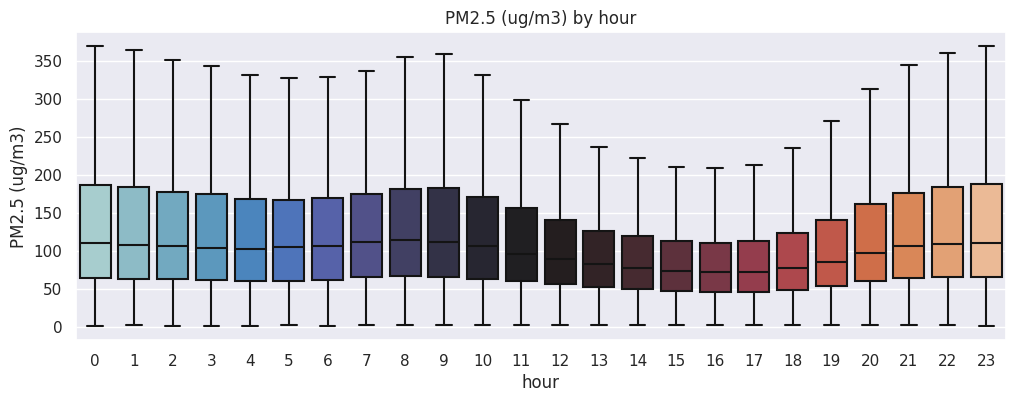

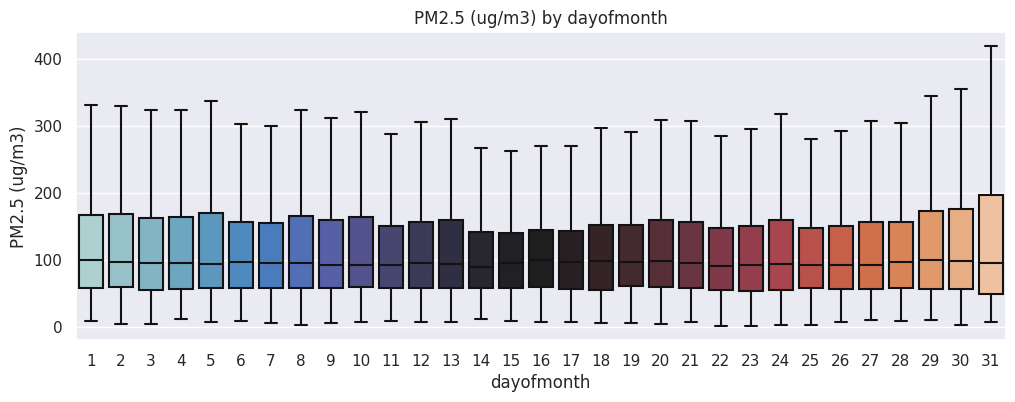

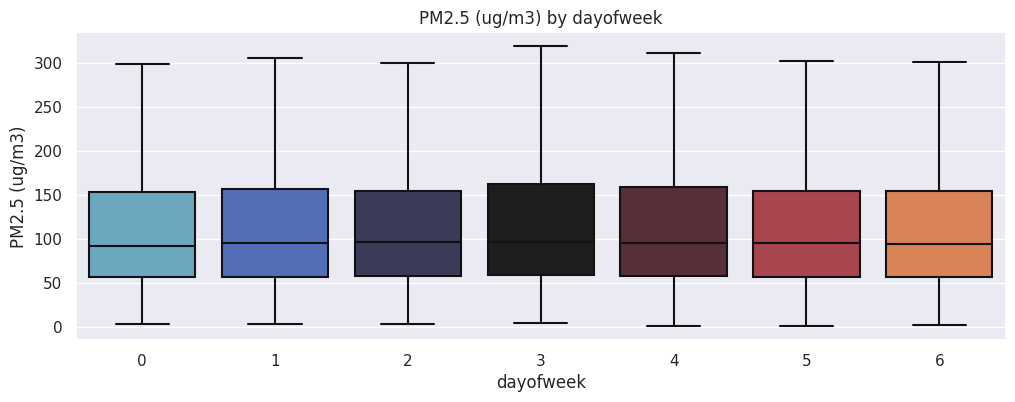

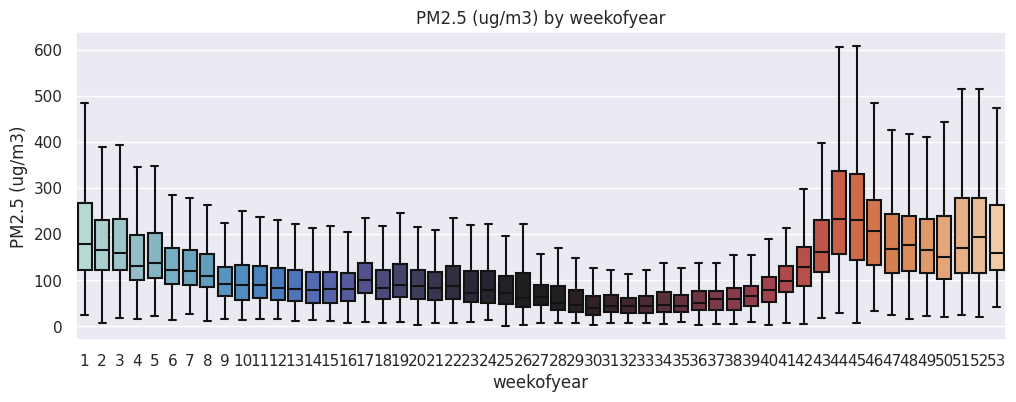

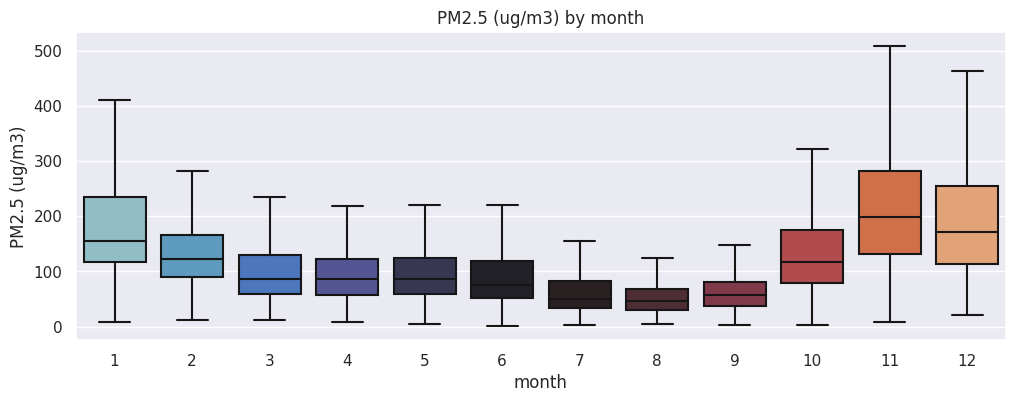

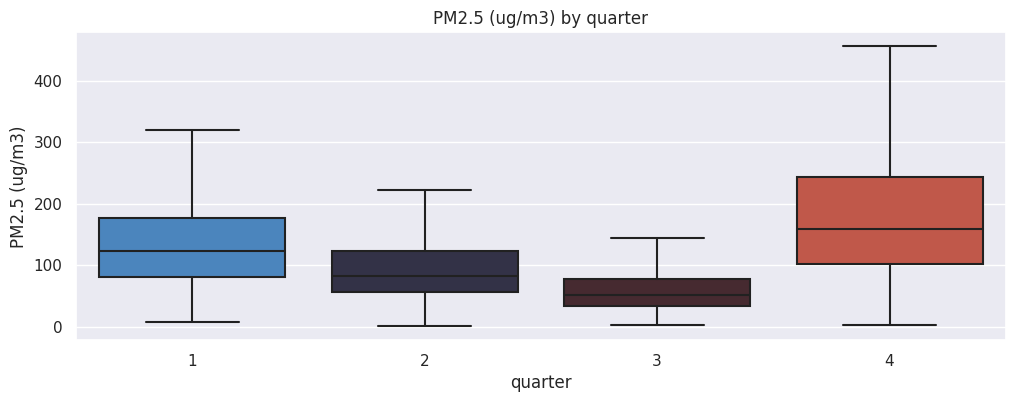

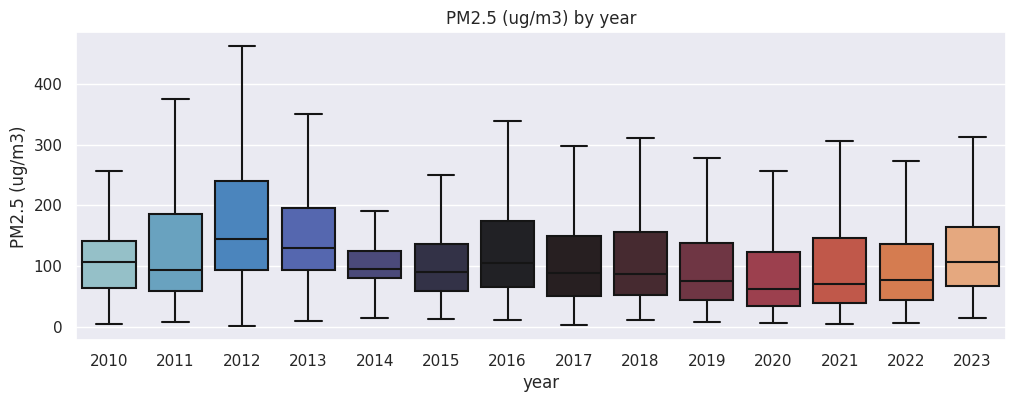

In [139]:
plot_by_datetime('PM2.5 (ug/m3)', ['hour', 'dayofmonth', 'dayofweek', 'weekofyear', 'month', 'quarter', 'year'])

These plots indicate that the various datetime groups capture important trends and information. What's also interesting here is that the 'dayofweek' feature vector, may not be as important, as it seems that the distribution is pretty similar to all days. Regardless, we will feed all this additional information to our model.

# Lag Features
Lag features capture information about a variable in a prior time step. In the case of forecasting, such lag features are likely to be predictive and help our models. What's more, we can also include lag features based on other predictive features in order to improve the forecasting accuracy.

From the previous few box plots we can see that some of the created timely features show some trends about the dataset. I will try to use some of these findings by creating appropriate lag features.

In [140]:
def create_lag_features(df):
    df = df.copy()
    df['pm_lag_1Y'] = df['PM2.5 (ug/m3)'].shift(365*24)   # 1 year lag
    df['pm_lag_2Y'] = df['PM2.5 (ug/m3)'].shift(730*24)   # 2 year lag
    return df

In [141]:
lag_features = ['pm_lag_1Y', 'pm_lag_2Y']
df = create_lag_features(df)
df.head()

,PM2.5 (ug/m3),NOx (ppb),Ozone (ug/m3),CO (mg/m3),hour,dayofmonth,dayofweek,dayofyear,weekofyear,month,quarter,year,pm_lag_1Y,pm_lag_2Y
datetime,,,,,,,,,,,,,,
2010-01-01 00:00:00,123.404029,73.7425,26.0650,2.340000,0,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 01:00:00,123.404029,36.0000,20.3425,2.327500,1,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 02:00:00,123.404029,27.1900,11.0650,2.177500,2,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 03:00:00,123.404029,21.1125,18.4625,1.992500,3,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 04:00:00,123.404029,23.1550,13.7500,2.096667,4,1,4,1,53,1,1,2010,NaN,NaN


After creating the lag features, we can see that the very first records (earliest measurements possible), have missing values. This is normal as we do not have previous observations that this point. However, we should be careful on how we deal with those values, as some models (especially sklearn's ensemble) do not support data with missing values.

For that reason I am going to create a function to deal with those values, for the ensemble models that do not support missing values. I should say that I am doing this purely for investigative reasons, to have some form of comparisons between models. This may introduce some bias and/or loose some information especially from the early year of measurements.

In [142]:
def replace_lag_na(df, how):
    '''
    Replaces missing values by applying various methods.
    
    Some additional ideas to implement include:
      1. Replace lag NaNs with the overall chosen method for that variable
      2. Replace lag NaNs with the time chosen method for the variable in the window value
    '''

    # Replace lag NaNs with zeros
    if how == 'zeros':
        return df.fillna(0)
    # Drop missing lag records
    if how == 'drop':
        return df.dropna(how='any')


# Time Series Forecasting
I will perform time series forecasting based on our extended analysis. I am going to compare various well known models, and present the results.ues.

## Dataset Preparation

Since I will try to compare many models at once, some of these model do not support missing values introducted by the lag features. To be completely fair across models I will drop all of such records. However bare in mind that by doing so, I am deleting a year's worth of information. There are models, for instance XGBoost or sklearn's HistGradientBoosting regressor, which accept missing values.

In [143]:
target = 'PM2.5 (ug/m3)'
predictors = date_features + lag_features

In [144]:
def create_train_test_sets(dataframe, split, replace_na=False, method='none'):
    '''
    Creates the training and testing sets for prediction.

    Parameters
    ----------
        dataframe (DataFrame): The DataFrame to exctract the train and test sets
        split (float): The percentage to split the dataset
        replace_na (bool): Option to replace/remove missing values from the sets
        method (string): The method of dealing with missing values. Options include `zeros` or `drop`

    Return
    ------
        X_train (DataFrame): The training set
        X_test (DataFrame): The testing set
        y_train (Series): The y values of the training set
        y_test (Series): The y values of the testing set
    '''
    
    dataframe = dataframe.copy()
    
    if replace_na:
        dataframe = replace_lag_na(dataframe, how=method)
        
    train_set, test_set = np.split(dataframe, [int(len(df) * split)])
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]


In [145]:
X_train, X_test, y_train, y_test = create_train_test_sets(df, split=0.8, replace_na=True, method='drop')

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Ensemble Methods

In [146]:
ensemble_models = {
    'Random Forest':     RandomForestRegressor(random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingRegressor(random_state=RANDOM_STATE),
    'AdaBoost':          AdaBoostRegressor(random_state=RANDOM_STATE),
    'Histogram GB':      HistGradientBoostingRegressor(random_state=RANDOM_STATE),
    'XGBoost':           xgb.XGBRegressor(random_state=RANDOM_STATE)
}

## Model Evaluation Metrics

1. **R² (Coefficient of Determination)**:  
   This metric measures how well a statistical model predicts the dependent variable. It indicates the proportion of variance in the dependent variable that is predictable from the independent variables.  
   - **Range**: 0 to 1, where 1 indicates a perfect fit.
   - **Interpretation**: If the R² for test data (R²_test) is significantly lower than R² for training data (R²_train), it suggests the model may not generalize well to unseen data.  
   **(Higher is better)**

2. **Root Mean Squared Error (RMSE)**:  
   RMSE measures the standard deviation of the prediction errors (residuals). It penalizes large errors and gives more weight to significant deviations from the actual values.  
   - **Formula**:  
     \[
     RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}
     \]
   **(Lower is better)**

3. **Mean Absolute Error (MAE)**:  
   MAE calculates the average of the absolute differences between the predicted and actual values. Unlike RMSE, it is not sensitive to outliers because it doesn’t square the errors.  
   - **Formula**:  
     \[
     MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|
     \]
   **(Lower is better)**

4. **Mean Absolute Percentage Error (MAPE)**:  
   MAPE measures the accuracy of a forecasting model by calculating the average percentage error between actual and predicted values. It gives insights into how far off the predictions are, in percentage terms.  
   - **Formula**:  
     \[
     MAPE = \frac{1}{n}\sum_{i=1}^{n}\left|\frac{y_i - \hat{y}_i}{y_i}\right| \times 100
     \]
   **(Lower is better)**
n average. (Lower is better)

In [147]:
def get_estimator_scores(models):
    '''
    Uses various metric algorithms to calculate various scores for multiple estimators
    '''
    metrics = []

    for model_name, model in models.items():            
        model.fit(X_train, y_train)
        predictions_test = model.predict(X_test)
        
        metrics.append([
            model_name,
            model.score(X_train, y_train),
            r2_score(y_test, predictions_test),
            np.sqrt(mean_squared_error(y_test, predictions_test)),
            mean_absolute_error(y_test, predictions_test),
            mean_absolute_percentage_error(y_test, predictions_test)
        ])
    
    return pd.DataFrame(metrics, columns=['model', 'r2_train', 'r2_test', 'rmse', 'mae', 'mape'])


In [148]:
estimator_scores = get_estimator_scores(ensemble_models)

In [149]:
def plot_estimator_scores(scores):
    melted_r2 = scores[['model', 'r2_train', 'r2_test']].rename(columns={"r2_train": "train", "r2_test": "test"})
    melted_r2 = melted_r2.melt(id_vars='model', var_name='set', value_name='score')
        
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.3, wspace=0.4)
    
    sns.barplot(data=melted_r2.round(2), x='score', y='model', hue='set', orient='h', ax=axes[0,0])
    sns.barplot(data=scores.round(2), x='rmse', y='model', orient='h', ax=axes[0,1])
    sns.barplot(data=scores.round(2), x='mae', y='model', orient='h', ax=axes[1,0])
    sns.barplot(data=scores.round(2), x='mape', y='model', orient='h', ax=axes[1,1])
    
    axes[0,0].set_title('R2 Score')
    axes[0,0].bar_label(axes[0,0].containers[0], size=10, padding=5)
    axes[0,0].bar_label(axes[0,0].containers[1], size=10, padding=5)
    axes[0,0].set(xlabel=None, ylabel=None)
    axes[0,0].set_xlim(0, max(melted_r2['score'])+.5)

    axes[0,1].set_title('Root Mean Squared Error')
    axes[0,1].bar_label(axes[0,1].containers[0], size=10, padding=5)
    axes[0,1].set(xlabel=None, ylabel=None)
    axes[0,1].set_xlim(0, max(scores['rmse'])+12)
    
    axes[1,0].set_title('Mean Absolute Error')
    axes[1,0].bar_label(axes[1,0].containers[0], size=10, padding=5)
    axes[1,0].set(xlabel=None, ylabel=None)
    axes[1,0].set_xlim(0, max(scores['mae'])+10)
    
    axes[1,1].set_title('Mean Absolute Percentage Error')
    axes[1,1].bar_label(axes[1,1].containers[0], size=10, padding=5)
    axes[1,1].set(xlabel=None, ylabel=None)
    axes[1,1].set_xlim(0, max(scores['mape'])+0.1)
    
    plt.plot()

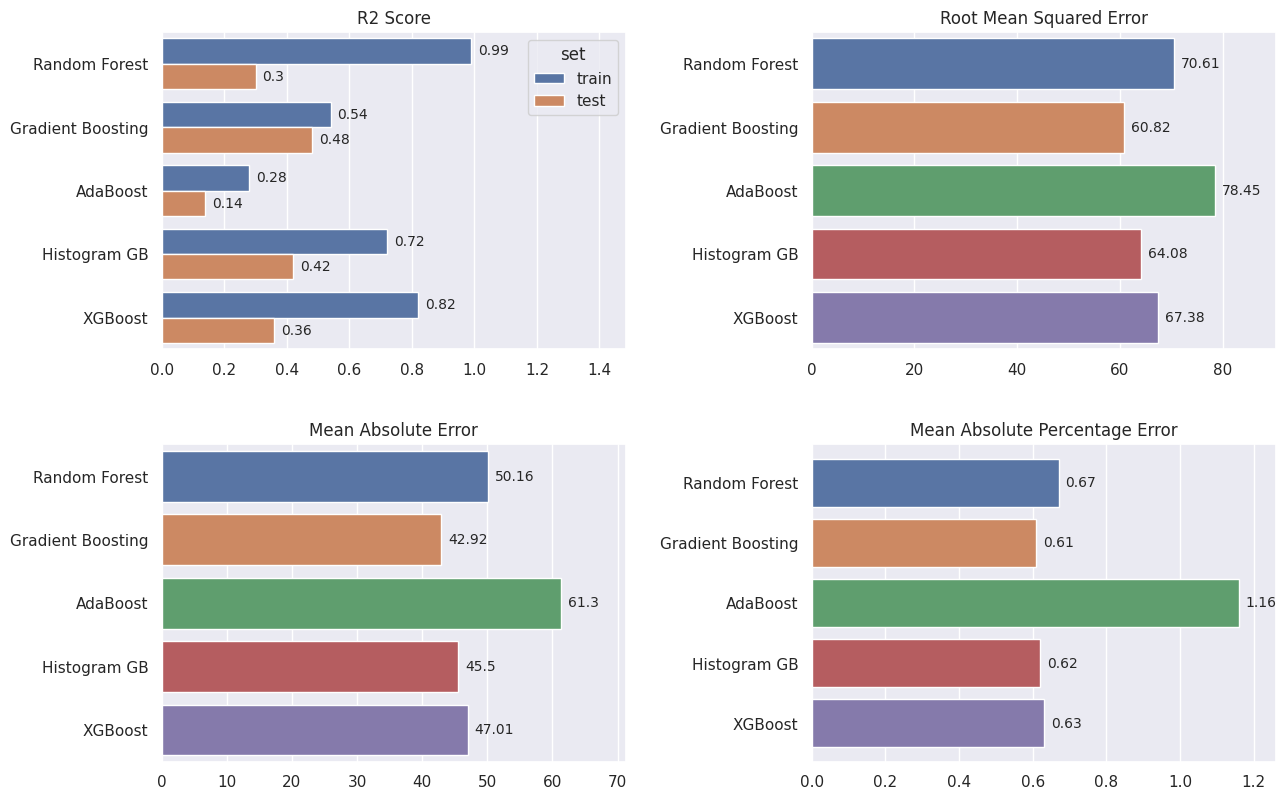

In [150]:
plot_estimator_scores(estimator_scores)

# Cross-Validation
Cross-validation is a technique in machine learning that is used to evaluate predictive performance in estimators. On each iteration, the algorithm splits the input data into two parts, a training set and an evaluation set (folds). The model is then trained on the training fold, and its performance is evaluated against the other validation fold. It is mainly used when we want to estimate how accurately a predictive model will perform and generalize to unseen data.

In this notebook we are dealing with time series data. The dataset contains time records in ascending order and randomly spliting it into various folds will not be ideal, since we want to predict future values. In that case we use another kind of cross-validation called TimeSeriesSplit. This technique splits the time series data into fixed time intervals as train/test sets. These splits advance in time, with each new split containing records that must be higher than the previous one.

Let's actually observe the resulting splits for our testing dataset.

In [151]:
tscv = TimeSeriesSplit(n_splits=5)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

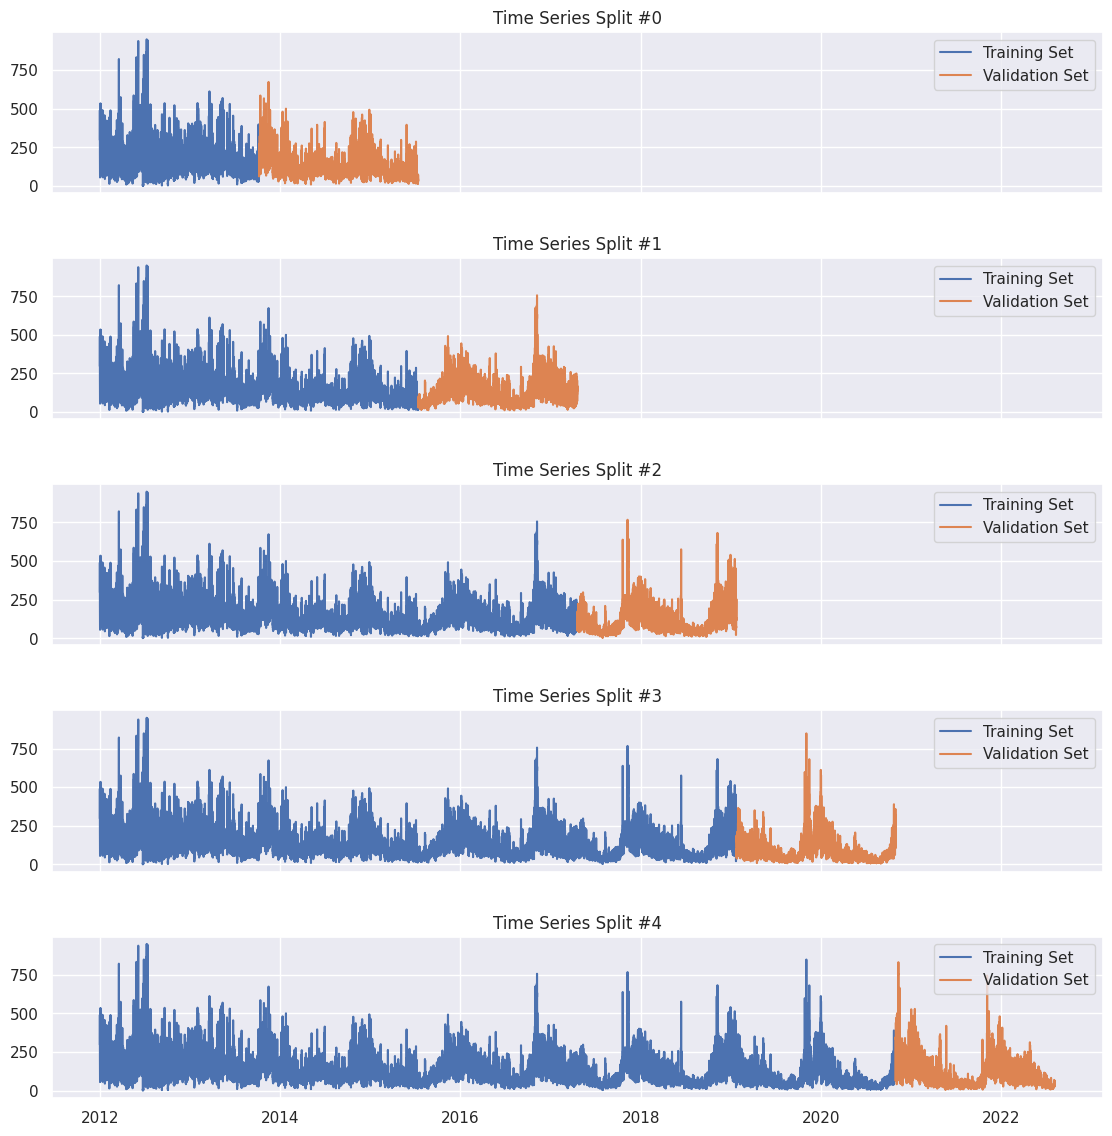

In [152]:
fig, axes = plt.subplots(tscv.n_splits, 1, figsize=(12, 12), sharex=True)
fig.tight_layout(pad=3.0)
    
for index, (train_fold, validation_fold) in enumerate(tscv.split(y_train)):
    sns.lineplot(data=y_train.iloc[train_fold], label='Training Set', ax=axes[index])
    sns.lineplot(data=y_train.iloc[validation_fold], label='Validation Set', ax=axes[index])
    axes[index].set_title(f'Time Series Split #{index}')
    axes[index].set(xlabel=None, ylabel=None)
    
plt.show()

Now I will perform cross-validation for all our models and share the results.



In [153]:
def get_cross_val_scores(models, x, y, cv, scoring):
    '''
    Get cross validated scores for input models.

    Parameters
    ----------
        models (dict): Dictionary containing the name of the model and the estimator object.
        x (DataFrame): A DataFrame containing the feature values to train upon.
        y (DataFrame): A Series object containing the actual predicted values.
        cv (CrossValidator or int): The cross-validation technique. An int value will perform k-fold CV.
        scoring (string): The scoring metric to evaluate the models.

    Return
    ------
        results (DataFrame): A DataFrame which contains the results for the CV run.
    '''
    
    measurements = [(model_name, i, score)
                    for model_name, model in ensemble_models.items()
                    for i, score in enumerate(-cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=N_JOBS))]

    results = pd.DataFrame(measurements, columns=['model', 'fold', 'score'])
    return results

In [154]:
cv_results = get_cross_val_scores(ensemble_models, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


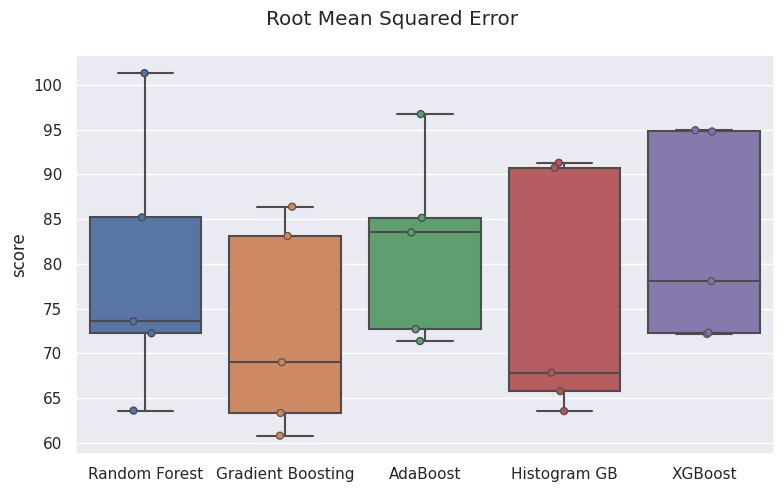

In [155]:
plt.figure(figsize=(8,5))
plt.suptitle('Root Mean Squared Error')

cs_metrics_bxplt = sns.boxplot(x='model', y='score', data=cv_results)
cs_metrics_stplt = sns.stripplot(x='model', y='score', hue='model', data=cv_results,
                                 size=5, jitter=True, linewidth=1, legend=False)

cs_metrics_bxplt.tick_params(labelsize=11)
cs_metrics_bxplt.set(xlabel=None)
plt.tight_layout()
plt.show()

In [156]:
cv_results.groupby('model').score.mean().sort_values()

model
Gradient Boosting    72.537031
Histogram GB         75.846163
Random Forest        79.193516
AdaBoost             81.899659
XGBoost              82.460902
Name: score, dtype: float64

# hyperparameter Tuning
We are now presented with design choices in order to achieve an optimal model architecture. These choices can be made with the form of parameters, which are refered to as hyperparameters. Those values are not automatically learned and we have to tune them. However we don't immediatelly know which parameters to tune and we may have to explore a huge range of possibilities. So we create a mapping of hyperparameters and the search space we want to explore.

This is where we can use two popular methods of hyperparameter tuning, the GridSearch and the RandomSearch. The first option exhaustively searches every possible combination of those hyperparaters which yields the best result at the cost of being extremelly slow. The latter option, picks random subsets of the search space thus being faster and usually providing an adequate result. I'm going to use RandomSearch for this notebook.

In [157]:
# Hyperparameter configurations for RandomizedSearch
model_hyperparameters = {
    'Random Forest': {'n_estimators': [100,150,200],
                      'min_samples_split': [2,5],
                      'min_samples_leaf': [2,4,10],
                      'max_depth': [5,10],
                      'n_jobs': [N_JOBS],
                      'random_state': [RANDOM_STATE]},
    
    'Gradient Boosting': {'learning_rate': np.arange(0.01,1,0.01),
                          'n_estimators': [100,200,300],
                          'min_samples_split': [2,5],
                          'min_samples_leaf': [1,4,10],
                          'max_depth': [3,5],
                          'n_iter_no_change': [10],
                          'tol': [0.01],
                          'random_state': [RANDOM_STATE]},
    
    'AdaBoost': {'learning_rate': np.arange(0.01,1,0.01),
                 'n_estimators': [50,100,200,300],
                 'random_state': [RANDOM_STATE]},
    
    'Histogram GB': {'learning_rate': np.arange(0.01,1,0.01),
                     'max_iter': [100,150,200],
                     'min_samples_leaf': [10,20,30],
                     'max_depth': [None,3,5,10],
                     'n_iter_no_change': [10],
                     'tol': [0.01],
                     'random_state': [RANDOM_STATE]},
    
    'XGBoost': {'learning_rate': np.arange(0.01,1,0.01),
                'n_estimators': [20,50,100,250],
                'max_depth': [None,3,5],
                'eval_metric': ['rmse'],
                'early_stopping_rounds': [10],
                'n_jobs': [N_JOBS],
                'random_state': [RANDOM_STATE]}
}

In [158]:
def random_search_cv(models, params, n_iter, cv, scoring):
    '''
    Performs hyperparameter tuning using RandomizedSearch.

    Parameters
    ----------
        models (dict): Dictionary containing the name of the model and its respective estimator object.
        params (dict): Dictionary containing the name of the model and its respective hyperparameter spaces to search.
        n_iter (int): The number of candidates to choose from the search space.
        cv (CrossValidator or int): The cross-validation technique. An int value will perform k-fold CV.
        scoring (string): The scoring metric to evaluate the models.

    Return
    ------
        models (dict): A dictionary containing the name of the model and the tuned model parameters.
        model_scores (DataFrame): DataFrame indicating the model's name and the attained best score.
    '''
    
    print(f'Fitting {tscv.n_splits} folds for each of {n_iter} candidates, totalling {tscv.n_splits*n_iter} fits.\n')
    
    model_scores = []

    for model_name, model in ensemble_models.items():
        start = time.time()

        # Use RandomizedSearch as the search space is quite big. For more accurate results we can use GridSearch.
        rscv_model = RandomizedSearchCV(model, params[model_name],
                                        cv=cv,
                                        scoring=scoring,
                                        return_train_score=True,
                                        n_jobs=N_JOBS,
                                        n_iter=n_iter,
                                        random_state=RANDOM_STATE)

        if model_name == 'XGBoost':
            rscv_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)
        else:
            rscv_model.fit(X_train, y_train)
        end = time.time()

        print(f'Randomized Search CV for {model_name} finished after {round(end-start, 2)} seconds. Best parameters found:')
        print(f'{rscv_model.best_params_}\n')

        models[model_name] = rscv_model.best_estimator_
        model_scores.append((model_name, round(-rscv_model.best_score_, 4)))
        
    model_scores = pd.DataFrame(model_scores, columns=['model', 'score'])
    
    return models, model_scores


In [159]:
ensemble_models, rscv_scores = random_search_cv(ensemble_models, model_hyperparameters, n_iter=20, cv=tscv, scoring="neg_root_mean_squared_error")

Fitting 5 folds for each of 20 candidates, totalling 100 fits.

Randomized Search CV for Random Forest finished after 658.18 seconds. Best parameters found:
{'random_state': 18, 'n_jobs': -1, 'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5}

Randomized Search CV for Gradient Boosting finished after 843.66 seconds. Best parameters found:
{'tol': 0.01, 'random_state': 18, 'n_iter_no_change': 10, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.17}

Randomized Search CV for AdaBoost finished after 200.51 seconds. Best parameters found:
{'random_state': 18, 'n_estimators': 100, 'learning_rate': 0.01}

Randomized Search CV for Histogram GB finished after 55.3 seconds. Best parameters found:
{'tol': 0.01, 'random_state': 18, 'n_iter_no_change': 10, 'min_samples_leaf': 30, 'max_iter': 100, 'max_depth': 5, 'learning_rate': 0.05}

Randomized Search CV for XGBoost finished after 22.17 seconds. Best parameter

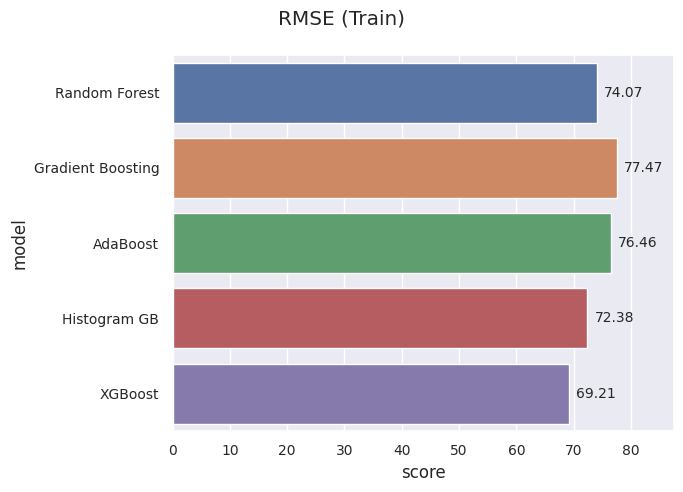

In [160]:
fig = plt.figure(figsize=(7,5))
fig.suptitle("RMSE (Train)")

metrics_plt = sns.barplot(rscv_scores.round(2), x='score', y='model', orient='h')
metrics_plt.tick_params(labelsize=10)
metrics_plt.bar_label(metrics_plt.containers[0], size=10, padding=5)

plt.xlim(0, max(rscv_scores.score)+10)
plt.tight_layout()
plt.show()

Let's now evaluate the tuned models on their ability to predict unseen data (testing set) and also measure the time needed to train and make predictions.

In [161]:
time_metrics = []
for model_name, model in ensemble_models.items():
    
    fit_start = time.time()
    if model_name == 'XGBoost':
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)
    else:
        model.fit(X_train, y_train)
    fit_end = time.time()

    pred_start = time.time()
    predictions_test = model.predict(X_test)
    pred_end = time.time()

    time_metrics.append([
        model_name,
        np.sqrt(mean_squared_error(y_test, predictions_test)),
        fit_end-fit_start,
        pred_end-pred_start
    ])
    
time_metrics = pd.DataFrame(time_metrics, columns=['model', 'rmse', 'fit_time', 'predict_time'])


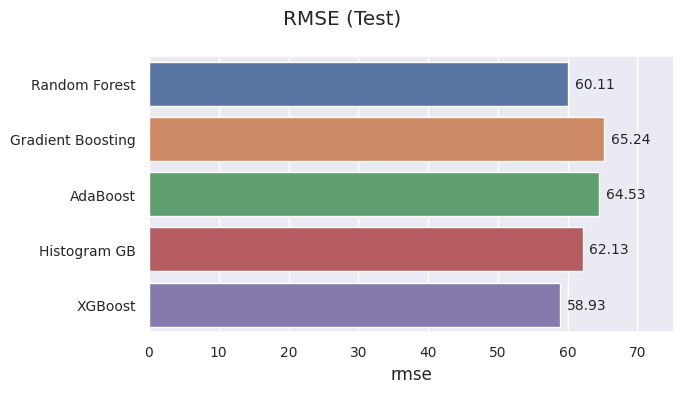

In [162]:
fig = plt.figure(figsize=(7,4))
fig.suptitle("RMSE (Test)")
metrics_plt = sns.barplot(time_metrics.round(2), x='rmse', y='model', orient='h')
metrics_plt.tick_params(labelsize=10)
metrics_plt.bar_label(metrics_plt.containers[0], size=10, padding=5)
metrics_plt.set(ylabel=None)

plt.xlim(0, max(time_metrics.rmse)+10)
plt.tight_layout()
plt.show()

All models perform similarly in the testing set as well. The lowest scores are given by XGBoost and Random Forests, by a tight margin.

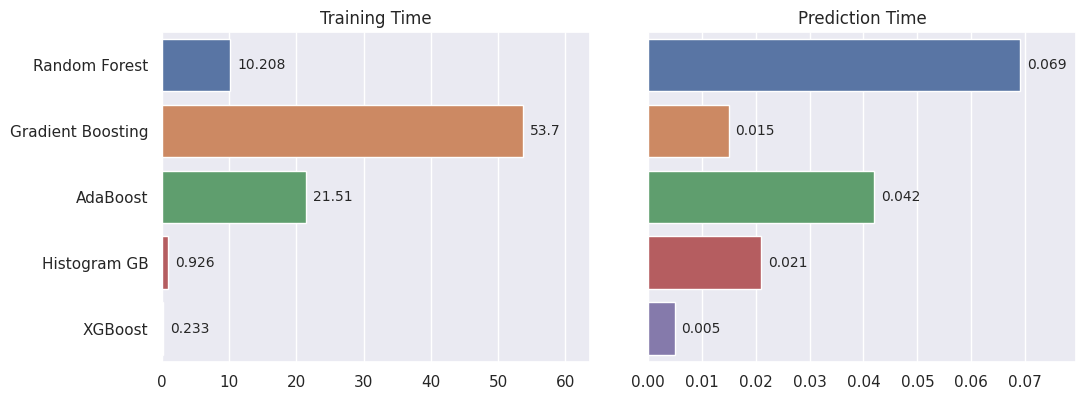

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
fig.tight_layout(w_pad=2.0)

sns.barplot(time_metrics.round(3), x='fit_time', y='model', orient='h', ax=axes[0])
axes[0].bar_label(axes[0].containers[0], size=10, padding=5)
axes[0].set_xlim(0, max(time_metrics.fit_time)+10)
axes[0].set(xlabel=None, ylabel=None)
axes[0].set_title('Training Time')

sns.barplot(time_metrics.round(3), x='predict_time', y='model', orient='h', ax=axes[1])
axes[1].bar_label(axes[1].containers[0], size=10, padding=5)
axes[1].set_xlim(0, max(time_metrics.predict_time)+0.01)
axes[1].set(xlabel=None, ylabel=None)
axes[1].set_title('Prediction Time')

plt.show()

Plotting the time needed for training and prediction, we can spot some differences. Random Forests and Gradient Boosting perform the worse when it comes to model training. In addition to this, Random Forests also have the worst performance during prediction. So in my opinion, if we were to choose one model it would be either the experimental Histogram GB or the pretty famous XGBoost.
ns.

# Feature Importances
Feature Importance refers to the calculation of the score for all the input features for a given model. These scores represent the importance each feature that was assigned by the model. A higher score means that the specific feature has a higher influence on the model that is used to make predictions.

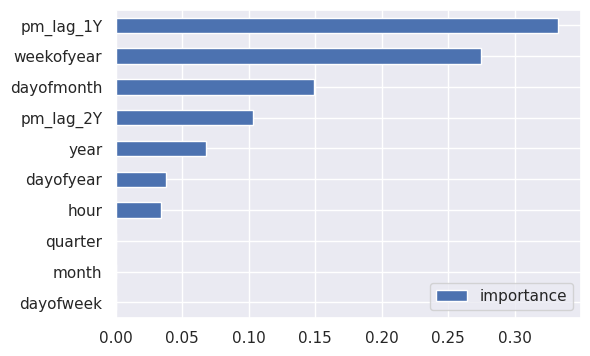

In [164]:
feature_importances_df = pd.DataFrame(data=ensemble_models['XGBoost'].feature_importances_,
                                      index=ensemble_models['XGBoost'].feature_names_in_,
                                      columns=['importance'])
feature_importances_df.sort_values('importance').plot(kind='barh', figsize=(6,4)).legend(loc='lower right')

# Future Predictions
Next I will let these models make predictions on completely new data about the future (forecasting). We will also visually inspect the results to have a better understanding of how each model tries to come up with future predictions.

In [165]:
def create_future_dataset(raw_data, start_date, end_date):
    '''
    Get cross validated scores for input models.

    Parameters
    ----------
        raw_data (DataFrame): The original dataset to gather insights from.
        start_date (string): The starting date to use for forecasting.
        end_date (string): The last date to use for forecasting.

    Return
    ------
        future_dataset (DataFrame): A DataFrame which contains the created dataset with future datetime indices.
    '''
    
    future_dataset = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='1H'), columns=['datetime'])
    future_dataset = future_dataset.set_index('datetime')
    future_dataset = create_features(future_dataset)
    
    # Create lag features from raw data
    future_dataset['pm_lag_1Y'] = raw_data.loc[future_dataset.index - pd.Timedelta('365 days')][target].values
    future_dataset['pm_lag_2Y'] = raw_data.loc[future_dataset.index - pd.Timedelta('730 days')][target].values

    return future_dataset


In [166]:
future_df = create_future_dataset(df, start_date='2023-04-01', end_date='2024-03-30')

# Make sure the order of the features is the same as the one we fed to the models.
f_names = ensemble_models['XGBoost'].get_booster().feature_names
future_df = future_df[f_names]

/tmp/ipykernel_30/1084000353.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dataset = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='1H'), columns=['datetime'])


In [167]:
test_predictions = X_test.copy()
future_predictions = future_df.copy()

for model_name, model in ensemble_models.items():
    test_predictions[f'predict_{model_name}'] = model.predict(X_test)
    future_predictions[f'predict_{model_name}'] = model.predict(future_df)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

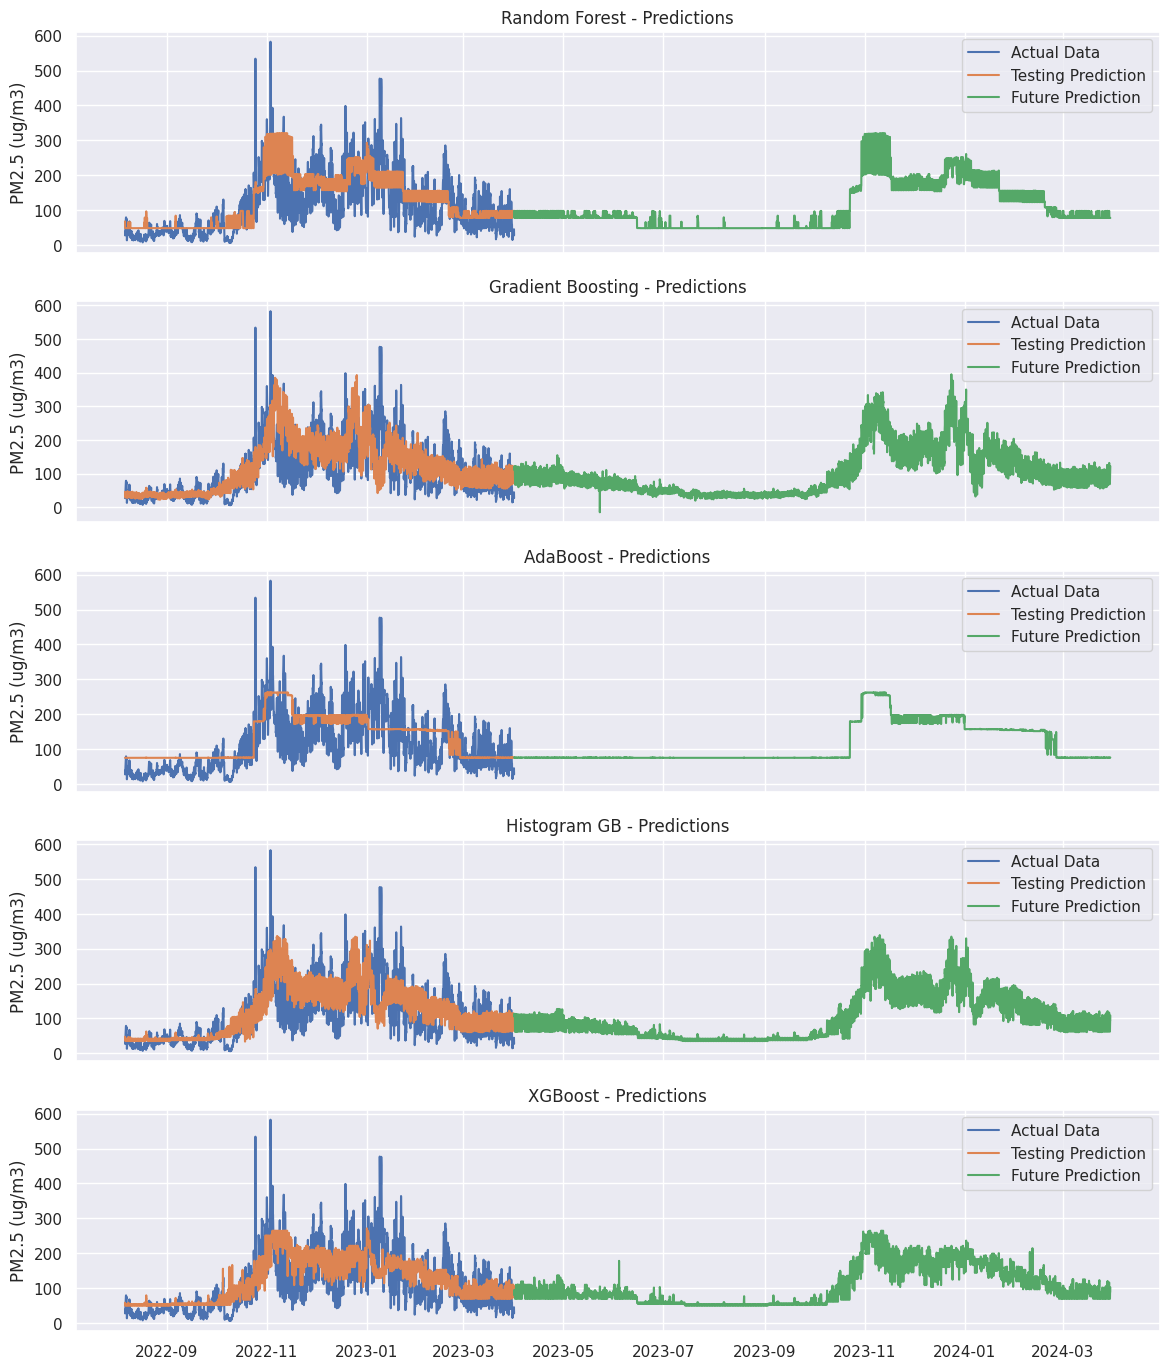

In [168]:
fig, axes = plt.subplots(5, 1, figsize=(12, 14), sharex=True)
fig.tight_layout(pad=2.0)

for index, (model_name, model) in enumerate(ensemble_models.items()):
    sns.lineplot(data=y_test, label="Actual Data", ax=axes[index])
    sns.lineplot(data=test_predictions[f'predict_{model_name}'], label="Testing Prediction", ax=axes[index])
    sns.lineplot(data=future_predictions[f'predict_{model_name}'], label="Future Prediction", ax=axes[index])
    axes[index].set_title(f'{model_name} - Predictions')
    axes[index].set(xlabel=None)
    
plt.show()

# Model Persistence
The results indicate that the XGBoost model performed the best for this task. I will save the model as a json file for easy loading.

In [170]:
try:
    os.mkdir('models')
except FileExistsError:
    pass